<a href="https://colab.research.google.com/github/trduc97/CS982/blob/main/full_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup Phase
Doing some initial setup work

### 1.1. Dependencies Setup
Importing all necessary libraries required for this notebook to function

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
! pip install scikit-learn==1.2.2
! pip install -U imbalanced-learn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import sklearn
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### For Implementation using Google Colab (OPTIONAL)

In [ ]:

from google.colab import drive
# Mounting
drive.mount('/content/drive', force_remount=True)
specific_path = '/content/drive/MyDrive/Strathclyde/CS982_Big_data_technologies'
os.chdir(specific_path)


Mounted at /content/drive


### 1.2. Data loading
Loading all necessary data from csv files into Pandas DataFrames

In [ ]:
# Reading the 'application_train' csv file into a DataFrame, and assigning it to the variable 'raw_applications'
raw_applications = pd.read_csv('application_train.csv')

# Reading the 'HomeCredit_columns_description' csv file into a DataFrame using 'ISO8859' encoding, and assigning it to the variable 'raw_descriptions'
raw_descriptions = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO8859')


### 1.3. Inspection & modification of the 'raw_descriptions' DataFrame (Complete)
Very briefly inspecting the 'raw_descriptions' DataFrame and cleaning it to suit our needs

In [ ]:
# Return the first 5 rows of the 'raw_descriptions' DataFrame
raw_descriptions.head()


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [ ]:
# Return the last 5 rows of the 'raw_descriptions' DataFrame
raw_descriptions.tail()


,Unnamed: 0,Table,Row,Description,Special
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


In [ ]:
# Defining a function to clean the 'raw_descriptions' DataFrame
def descriptions_cleaner() -> pd.DataFrame:
    # Storing a deep copy of the 'raw_descriptions' DataFrame's indices and data, and assigning it to the variable 'df'
    df = raw_descriptions.copy()

    # Filtering the 'df' DataFrame to remove rows that describe columns not found in the 'application_train' csv file
    df = df[df['Table'] == 'application_{train|test}.csv']

    # Dropping the 'Unnamed: 0' and 'Table' columns from the 'df' DataFrame in place
    df.drop(columns=['Unnamed: 0', 'Table'], inplace=True)

    # Renaming the 'Row' column to 'Column'
    df.rename(columns={'Row': 'Column'}, inplace=True)

    # Setting the index of the 'df' DataFrame to the 'Column' column
    df.set_index('Column', inplace=True)

    return df

# Cleaning the 'raw_descriptions' DataFrame using the 'descriptions_cleaner' function and assigning the output to the variable 'descriptions'
descriptions = descriptions_cleaner()

descriptions


,Description,Special
Column,,
SK_ID_CURR,ID of loan in our sample,NaN
TARGET,Target variable (1 - client with payment diffi...,NaN
NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
CODE_GENDER,Gender of the client,NaN
FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN


## 2. Exploratory Data Analysis

### 2.1 Initial inspection
Using Pandas functions to take a first look at the dataset

In [ ]:
# Return the first 5 rows of the 'raw_applications' DataFrame
raw_applications.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Return the last 5 rows of the 'raw_applications' DataFrame
raw_applications.tail()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [ ]:
# Return a random sample of 5 rows from the 'raw_applications' DataFrame
raw_applications.sample(5)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
136653,258496,0,Cash loans,M,Y,Y,0,112500.0,135000.0,10795.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0
259265,400047,0,Cash loans,F,Y,Y,1,135000.0,1125000.0,37179.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
227465,363476,0,Cash loans,F,N,N,1,90000.0,622188.0,22477.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
294210,440844,0,Cash loans,F,N,N,0,117000.0,99504.0,9841.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,6.0
222029,357202,0,Cash loans,F,N,Y,1,81000.0,258709.5,14980.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


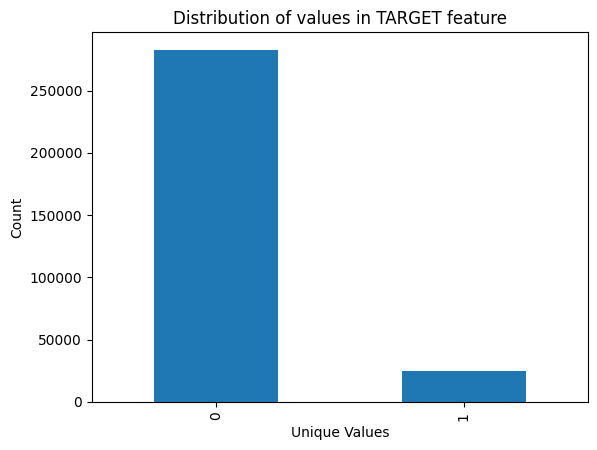

In [ ]:
import matplotlib.pyplot as plt
value_counts =raw_applications['TARGET'].value_counts()
# Assuming 'value_counts' contains the counts of unique values
value_counts.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of values in TARGET feature')
plt.show()


### 2.2. Structural inspection
Using Pandas functions to take a first look at the structure of the dataset

In [ ]:
# Storing a tuple representing the dimensionality of the 'raw_applications' DataFrame, and assigning it to the variable 'raw_applications_shape'
raw_applications_shape = raw_applications.shape

print(f"The 'raw_applications' DataFrame has {raw_applications_shape[0]} rows and {raw_applications_shape[1]} columns")


The 'raw_applications' DataFrame has 307511 rows and 122 columns


In [ ]:
# Printing a concise summary of the raw_applications DataFrame
raw_applications.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### 2.3. Data types investigation
Utilizing the 'descriptions' DataFrame to help check whether the data types of each column are as expected

In [ ]:
# Storing a deep copy of the 'descriptions' DataFrame's indices and data, and assigning it to the variable 'dtypes_applications'
dtypes_applications = descriptions.copy()

# Storing a Series with the data type of each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Data types'
dtypes_applications['Data types'] = raw_applications.dtypes

# Storing a Series containing an array of unique values from each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Unique Values'
dtypes_applications['Unique Values'] = raw_applications.apply(lambda c: c.unique())

# Storing a Series containing the number of distinct elements in each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Count Unique'
dtypes_applications['Count Unique'] = raw_applications.nunique()

dtypes_applications


,Description,Special,Data types,Unique Values,Count Unique
Column,,,,,
SK_ID_CURR,ID of loan in our sample,NaN,int64,"[100002, 100003, 100004, 100006, 100007, 10000...",307511
TARGET,Target variable (1 - client with payment diffi...,NaN,int64,"[1, 0]",2
NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN,object,"[Cash loans, Revolving loans]",2
CODE_GENDER,Gender of the client,NaN,object,"[M, F, XNA]",3
FLAG_OWN_CAR,Flag if the client owns a car,NaN,object,"[N, Y]",2
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN,float64,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ...",9
AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN,float64,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ...",9
AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN,float64,"[0.0, nan, 1.0, 2.0, 6.0, 5.0, 3.0, 7.0, 9.0, ...",24


#### Manual review of data type suitability for each column in the 'raw_applications' DataFrame

| Column                       | Data types | Expected data type | Suitable? |
|:-----------------------------|:-----------|:-------------------|:----------|
| SK_ID_CURR                   | int64      | Distinct           | Yes       |
| TARGET                       | int64      | Distinct           | Yes       |
| NAME_CONTRACT_TYPE           | object     | Nominal            | Yes       |
| CODE_GENDER                  | object     | Nominal            | Yes       |
| FLAG_OWN_CAR                 | object     | Nominal            | Yes       |
| FLAG_OWN_REALTY              | object     | Nominal            | Yes       |
| CNT_CHILDREN                 | int64      | Distinct           | Yes       |
| AMT_INCOME_TOTAL             | float64    | Distinct           | Yes       |
| AMT_CREDIT                   | float64    | Distinct           | Yes       |
| AMT_ANNUITY                  | float64    | Distinct           | Yes       |
| AMT_GOODS_PRICE              | float64    | Distinct           | Yes       |
| NAME_TYPE_SUITE              | object     | Nominal            | Yes       |
| NAME_INCOME_TYPE             | object     | Nominal            | Yes       |
| NAME_EDUCATION_TYPE          | object     | Ordinal            | Yes       |
| NAME_FAMILY_STATUS           | object     | Nominal            | Yes       |
| NAME_HOUSING_TYPE            | object     | Nominal            | Yes       |
| REGION_POPULATION_RELATIVE   | float64    | Continuous         | Yes       |
| DAYS_BIRTH                   | int64      | Distinct           | Yes       |
| DAYS_EMPLOYED                | int64      | Distinct           | Yes       |
| DAYS_REGISTRATION            | float64    | Distinct           | No        |
| DAYS_ID_PUBLISH              | int64      | Distinct           | Yes       |
| OWN_CAR_AGE                  | float64    | Distinct           | No        |
| FLAG_MOBIL                   | int64      | Nominal            | Yes       |
| FLAG_EMP_PHONE               | int64      | Nominal            | Yes       |
| FLAG_WORK_PHONE              | int64      | Nominal            | Yes       |
| FLAG_CONT_MOBILE             | int64      | Nominal            | Yes       |
| FLAG_PHONE                   | int64      | Nominal            | Yes       |
| FLAG_EMAIL                   | int64      | Nominal            | Yes       |
| OCCUPATION_TYPE              | object     | Nominal            | Yes       |
| CNT_FAM_MEMBERS              | float64    | Distinct           | No        |
| REGION_RATING_CLIENT         | int64      | Ordinal            | Yes       |
| REGION_RATING_CLIENT_W_CITY  | int64      | Ordinal            | Yes       |
| WEEKDAY_APPR_PROCESS_START   | object     | Nominal            | Yes       |
| HOUR_APPR_PROCESS_START      | int64      | Distinct           | Yes       |
| REG_REGION_NOT_LIVE_REGION   | int64      | Nominal            | Yes       |
| REG_REGION_NOT_WORK_REGION   | int64      | Nominal            | Yes       |
| LIVE_REGION_NOT_WORK_REGION  | int64      | Nominal            | Yes       |
| REG_CITY_NOT_LIVE_CITY       | int64      | Nominal            | Yes       |
| REG_CITY_NOT_WORK_CITY       | int64      | Nominal            | Yes       |
| LIVE_CITY_NOT_WORK_CITY      | int64      | Nominal            | Yes       |
| ORGANIZATION_TYPE            | object     | Nominal            | Yes       |
| EXT_SOURCE_1                 | float64    | Continuous         | Yes       |
| EXT_SOURCE_2                 | float64    | Continuous         | Yes       |
| EXT_SOURCE_3                 | float64    | Continuous         | Yes       |
| APARTMENTS_AVG               | float64    | Continuous         | Yes       |
| BASEMENTAREA_AVG             | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_AVG  | float64    | Continuous         | Yes       |
| YEARS_BUILD_AVG              | float64    | Continuous         | Yes       |
| COMMONAREA_AVG               | float64    | Continuous         | Yes       |
| ELEVATORS_AVG                | float64    | Continuous         | Yes       |
| ENTRANCES_AVG                | float64    | Continuous         | Yes       |
| FLOORSMAX_AVG                | float64    | Continuous         | Yes       |
| FLOORSMIN_AVG                | float64    | Continuous         | Yes       |
| LANDAREA_AVG                 | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_AVG         | float64    | Continuous         | Yes       |
| LIVINGAREA_AVG               | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_AVG      | float64    | Continuous         | Yes       |
| NONLIVINGAREA_AVG            | float64    | Continuous         | Yes       |
| APARTMENTS_MODE              | float64    | Continuous         | Yes       |
| BASEMENTAREA_MODE            | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_MODE | float64    | Continuous         | Yes       |
| YEARS_BUILD_MODE             | float64    | Continuous         | Yes       |
| COMMONAREA_MODE              | float64    | Continuous         | Yes       |
| ELEVATORS_MODE               | float64    | Continuous         | Yes       |
| ENTRANCES_MODE               | float64    | Continuous         | Yes       |
| FLOORSMAX_MODE               | float64    | Continuous         | Yes       |
| FLOORSMIN_MODE               | float64    | Continuous         | Yes       |
| LANDAREA_MODE                | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_MODE        | float64    | Continuous         | Yes       |
| LIVINGAREA_MODE              | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_MODE     | float64    | Continuous         | Yes       |
| NONLIVINGAREA_MODE           | float64    | Continuous         | Yes       |
| APARTMENTS_MEDI              | float64    | Continuous         | Yes       |
| BASEMENTAREA_MEDI            | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_MEDI | float64    | Continuous         | Yes       |
| YEARS_BUILD_MEDI             | float64    | Continuous         | Yes       |
| COMMONAREA_MEDI              | float64    | Continuous         | Yes       |
| ELEVATORS_MEDI               | float64    | Continuous         | Yes       |
| ENTRANCES_MEDI               | float64    | Continuous         | Yes       |
| FLOORSMAX_MEDI               | float64    | Continuous         | Yes       |
| FLOORSMIN_MEDI               | float64    | Continuous         | Yes       |
| LANDAREA_MEDI                | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_MEDI        | float64    | Continuous         | Yes       |
| LIVINGAREA_MEDI              | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_MEDI     | float64    | Continuous         | Yes       |
| NONLIVINGAREA_MEDI           | float64    | Continuous         | Yes       |
| FONDKAPREMONT_MODE           | object     | Nominal            | Yes       |
| HOUSETYPE_MODE               | object     | Nominal            | Yes       |
| TOTALAREA_MODE               | float64    | Continuous         | Yes       |
| WALLSMATERIAL_MODE           | object     | Nominal            | Yes       |
| EMERGENCYSTATE_MODE          | object     | Nominal            | Yes       |
| OBS_30_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DEF_30_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| OBS_60_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DEF_60_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DAYS_LAST_PHONE_CHANGE       | float64    | Distinct           | No        |
| FLAG_DOCUMENT_2              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_3              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_4              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_5              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_6              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_7              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_8              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_9              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_10             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_11             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_12             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_13             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_14             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_15             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_16             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_17             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_18             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_19             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_20             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_21             | int64      | Nominal            | Yes       |
| AMT_REQ_CREDIT_BUREAU_HOUR   | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_DAY    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_WEEK   | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_MON    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_QRT    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_YEAR   | float64    | Distinct           | No        |

##### Note on unsuitable data types:
Despite a number of columns containing 'unsuitable' data types, no changes to data types will be made. This is because the data is still being accurately represented (i.e. there are no half children in the CNT_CHILDREN column)


In [ ]:
# Generating descriptive statistics for the numerical columns in the 'raw_applications' DataFrame
raw_applications.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## 3. Data Cleaning

In [ ]:
# Dropping the 'SK_ID_CURR' column from the 'raw_applications' DataFrame
raw_applications.drop(columns='SK_ID_CURR', inplace=True)


### 3.1. Missing values imputation
Utilizing the 'descriptions' DataFrame to find and handle missing missing values

In [ ]:
# Storing a deep copy of the 'descriptions' DataFrame's indices and data, and assigning it to the variable 'missing_applications'
missing_applications = descriptions.copy()

# Storing the sum of a Series with missing values for each column in the 'raw_applications' DataFrame inside the 'missing_applications' DataFrame, and assigning it to the column 'Count NaN/None/NaT'
missing_applications['Count NaN/None/NaT'] = raw_applications.apply(lambda c: c.isnull().sum())

# Calculating the percentage of missing values for each column in the 'raw_applications' DataFrame inside the 'missing_applications' DataFrame, and assigning it to the column 'Count NaN/None/NaT'
missing_applications['Percentage NaN/None/NaT'] = (missing_applications['Count NaN/None/NaT'] / len(raw_applications)) * 100

# Filtering the 'missing_applications' DataFrame so that it only contains columns with more than 0 missing values
missing_applications = missing_applications[missing_applications['Count NaN/None/NaT'] > 0]

# Sort the 'missing_applications' DataFrame in place, by the values in the 'Percentage NaN/None/NaT' column
missing_applications.sort_values(by='Percentage NaN/None/NaT', inplace=True, ascending=False)

missing_applications


<ipython-input-16-ad5f9b089b66>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_applications.sort_values(by='Percentage NaN/None/NaT', inplace=True, ascending=False)


,Description,Special,Count NaN/None/NaT,Percentage NaN/None/NaT
Column,,,,
COMMONAREA_MEDI,Normalized information about building where th...,normalized,214865.0,69.872297
COMMONAREA_AVG,Normalized information about building where th...,normalized,214865.0,69.872297
COMMONAREA_MODE,Normalized information about building where th...,normalized,214865.0,69.872297
NONLIVINGAPARTMENTS_MEDI,Normalized information about building where th...,normalized,213514.0,69.432963
NONLIVINGAPARTMENTS_MODE,Normalized information about building where th...,normalized,213514.0,69.432963
...,...,...,...,...
EXT_SOURCE_2,Normalized score from external data source,normalized,660.0,0.214626
AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN,278.0,0.090403
AMT_ANNUITY,Loan annuity,NaN,12.0,0.003902


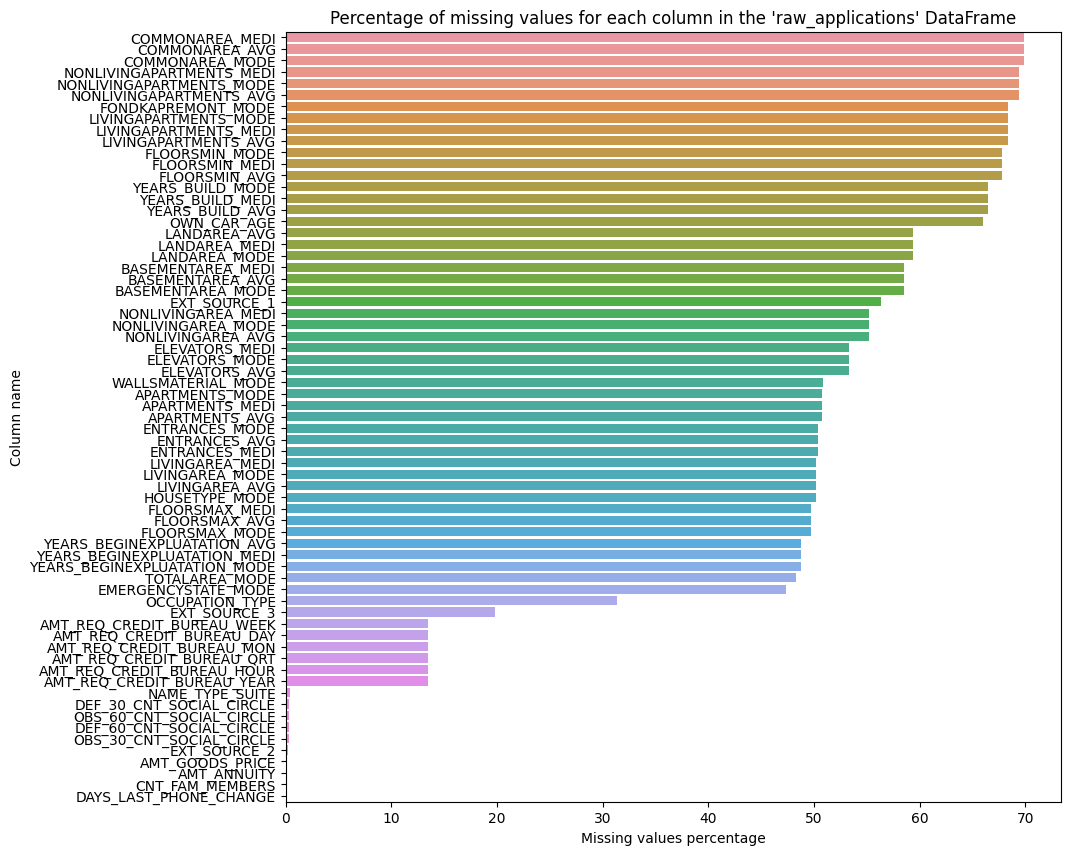

In [ ]:
# Visualising the percentage of missing values for each column in the 'raw_applications' DataFrame
plt.figure(figsize=(10, 10))
plt.title("Percentage of missing values for each column in the 'raw_applications' DataFrame")
sns.barplot(x=missing_applications['Percentage NaN/None/NaT'], y=missing_applications.index)
plt.xlabel("Missing values percentage")
plt.ylabel("Column name")
plt.show()


#### A brief word on the 'Missingness Mechanism'
We conducted an extensive investigation into the nature of missingness for out dataset but eventually concluded that it was not necessary.
Using 'Little's MCAR test' we found that the entire data frame could be classified as 'MCAR' (Missing completely at random) but there were
small groups of similar columns, identified by plotting a missingness matrix, whos missingness was clearly extremely closely linked and
when tested using Little's MCAR test were found to contain data not missing completely at random with p values reaching as low as 0.000001.
We decided not to investigate further as it was taking far too much time, and we were not asked to do this in any lecture.

#### Our strategy for dealing with missing values
As can be seen in the figure above, the columns within our dataset have largely varying amounts of missing data. This means there is really
no 'one solution to fit all' here. We therefore decided, due to the fact that our investigation into missingness was abandoned, to be rather
blunt with our approach to handling missing values. We initially planned to create some kind of formula that looked at each column and
combined its feature importance (defined by Spearman's rank correlation coefficient) with its proportion of missing values to calculate
whether to drop the column, impute it, or drop rows with missing values. This task however proved far too time consuming.

With all of this in mind, here are the criteria we followed when dealing with missing values in our data-set:

| Percentage of missing values in column | Strategy                                                                     |
|----------------------------------------|------------------------------------------------------------------------------|
| >33%                                   | Drop the entire column                                                       |
| >=3% and <=33%                         | Impute missing values using either median or mode depending on the data type |
| 0-3%                                   | Drop any rows in which values are missing                                    |




In [ ]:
# Sorting the columns with missing values into lists according to how they will be dealt with.

total_columns = len(raw_applications.columns)
columns_with_missing = (raw_applications.isnull().sum() > 0).sum()

columns_over_33 = missing_applications['Percentage NaN/None/NaT'] > 33
columns_to_drop = columns_over_33[columns_over_33].index.tolist()

columns_in_range_3_33 = (missing_applications['Percentage NaN/None/NaT'] >= 3) & (missing_applications['Percentage NaN/None/NaT'] <= 33)
columns_to_impute = columns_in_range_3_33[columns_in_range_3_33].index.tolist()

columns_under_3_not_0 = (missing_applications['Percentage NaN/None/NaT'] > 0) & (missing_applications['Percentage NaN/None/NaT'] < 3)
columns_drop_rows = columns_under_3_not_0[columns_under_3_not_0].index.tolist()

print(f"Of the {total_columns} columns in the 'raw_applications' DataFrame, missing values are present in {columns_with_missing} (~{round((columns_with_missing / total_columns) * 100)}%)\n")
print(f"{len(columns_to_drop)} columns are missing >33% of their values and will be dropped\n")
print(f"{len(columns_to_impute)} columns are missing from >=3% and <=33% of their values and will be imputed\n")
print(f"{len(columns_drop_rows)} columns are missing from >0% and <3% of their values. Rows missing values in these columns will be dropped\n")


Of the 121 columns in the 'raw_applications' DataFrame, missing values are present in 67 (~55%)

49 columns are missing >33% of their values and will be dropped

8 columns are missing from >=3% and <=33% of their values and will be imputed

10 columns are missing from >0% and <3% of their values. Rows missing values in these columns will be dropped



In [ ]:
# Dealing with missing values as described above
clean_applications = raw_applications.drop(columns=columns_to_drop)

clean_applications.dropna(subset=columns_drop_rows, inplace=True)

for column in columns_to_impute:
    if column == "OCCUPATION_TYPE":
        mode_value = clean_applications[column].mode()[0]
        clean_applications[column].fillna(mode_value, inplace=True)
    else:
        median_value = clean_applications[column].median()
        clean_applications[column].fillna(median_value, inplace=True)

print(f"There are now {clean_applications.isnull().sum().sum()} missing values in the 'clean_applications' DataFrame\n")

# Storing a tuple representing the dimensionality of the 'clean_applications' DataFrame, and assigning it to the variable 'clean_applications_shape'
clean_applications_shape = clean_applications.shape

print(f"The 'clean_applications' DataFrame has {clean_applications_shape[0]} rows and {clean_applications_shape[1]} columns")


There are now 0 missing values in the 'clean_applications' DataFrame

The 'clean_applications' DataFrame has 304531 rows and 72 columns


In [ ]:
# Creating a DataFrame of columns with the data type 'object' from the 'clean_applications' DataFrame
object_columns = clean_applications.select_dtypes(include=['object'])

#
object_columns_value_counts = object_columns.apply(lambda c: c.value_counts().to_dict())
object_columns_value_counts


NAME_CONTRACT_TYPE             {'Cash loans': 276613, 'Revolving loans': 27918}
CODE_GENDER                                {'F': 200482, 'M': 104045, 'XNA': 4}
FLAG_OWN_CAR                                         {'N': 200910, 'Y': 103621}
FLAG_OWN_REALTY                                       {'Y': 211641, 'N': 92890}
NAME_TYPE_SUITE               {'Unaccompanied': 247112, 'Family': 39969, 'Sp...
NAME_INCOME_TYPE              {'Working': 157341, 'Commercial associate': 70...
NAME_EDUCATION_TYPE           {'Secondary / secondary special': 216582, 'Hig...
NAME_FAMILY_STATUS            {'Married': 194660, 'Single / not married': 44...
NAME_HOUSING_TYPE             {'House / apartment': 270243, 'With parents': ...
OCCUPATION_TYPE               {'Laborers': 150165, 'Sales staff': 31790, 'Co...
WEEKDAY_APPR_PROCESS_START    {'TUESDAY': 53399, 'WEDNESDAY': 51418, 'MONDAY...
ORGANIZATION_TYPE             {'Business Entity Type 3': 67270, 'XNA': 54852...
dtype: object

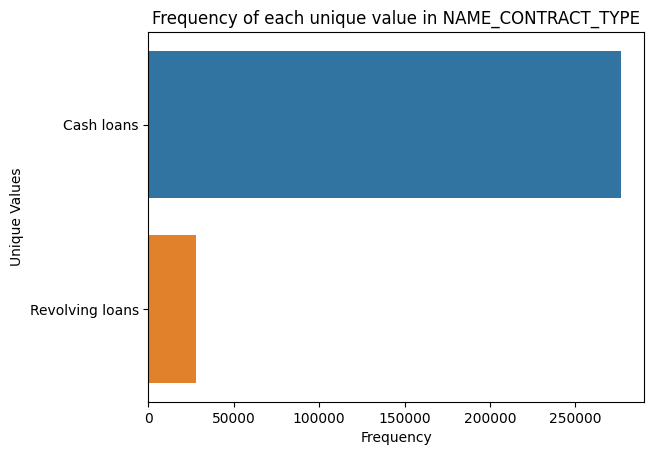

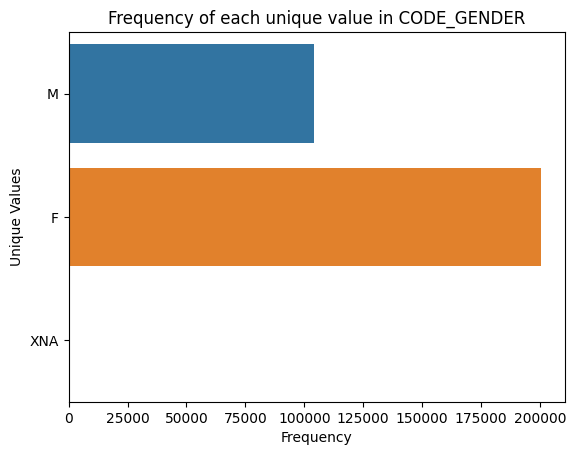

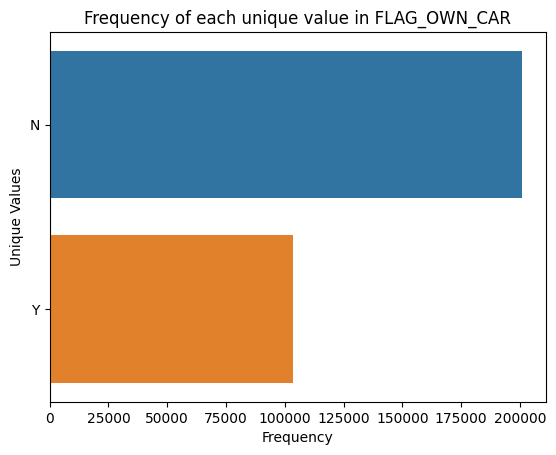

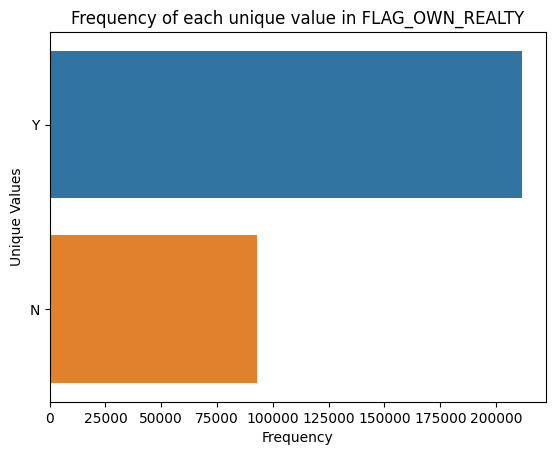

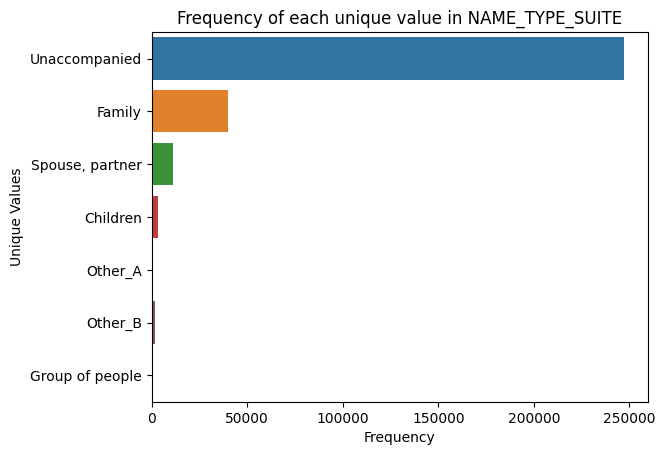

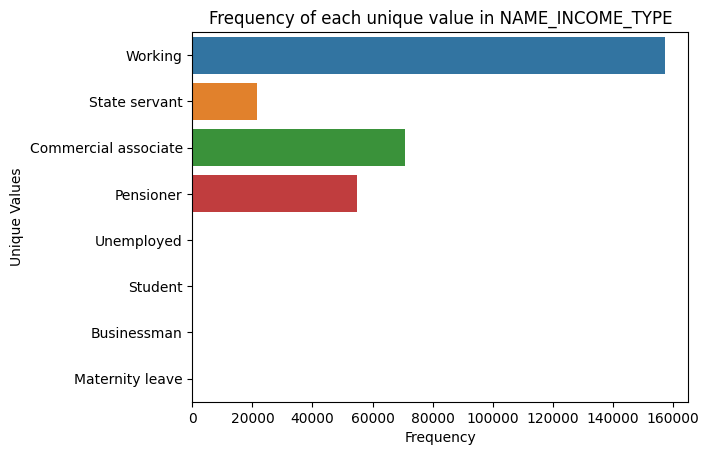

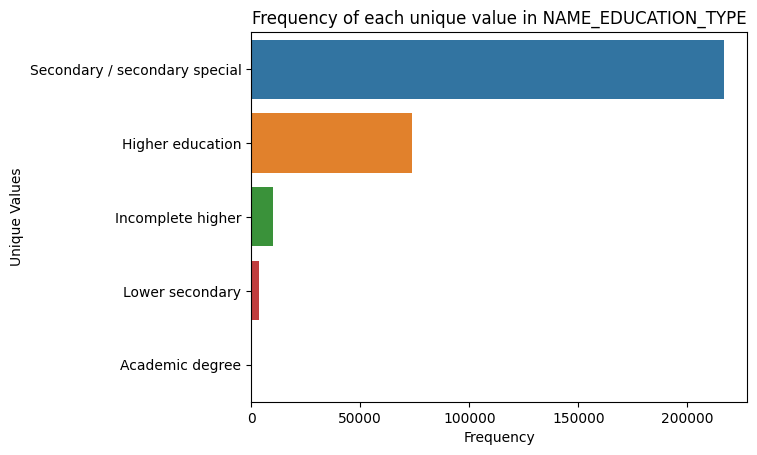

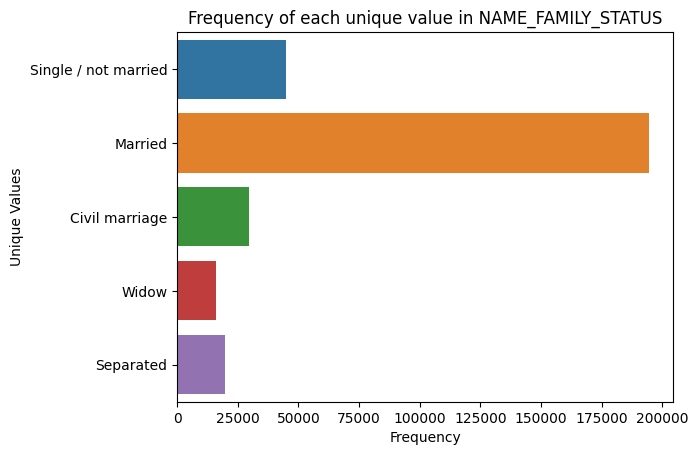

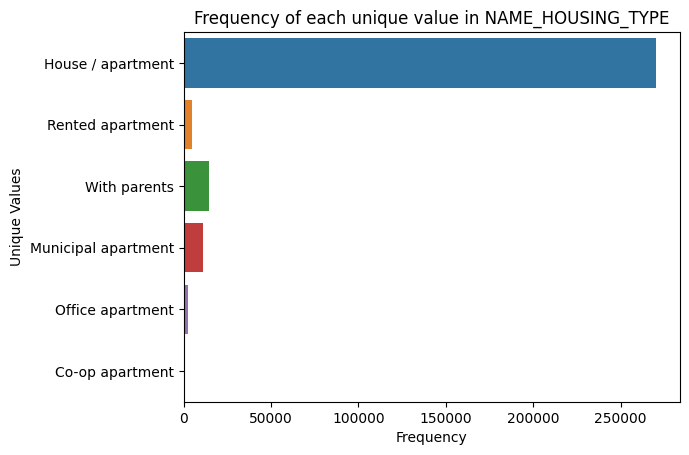

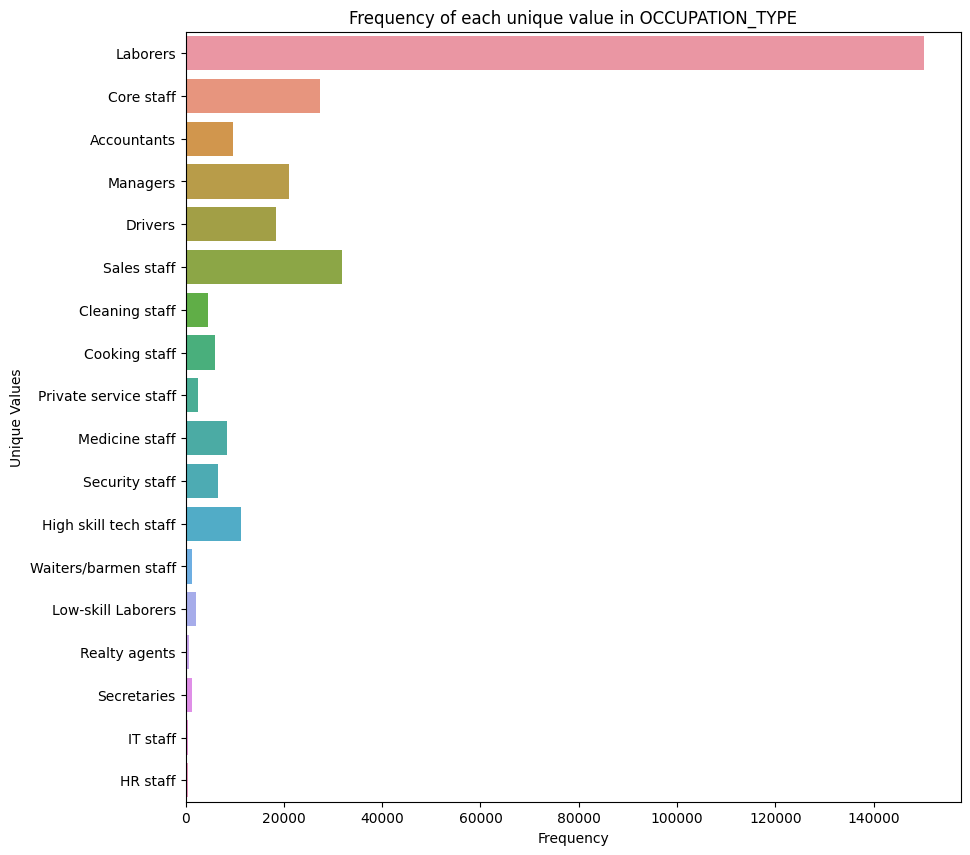

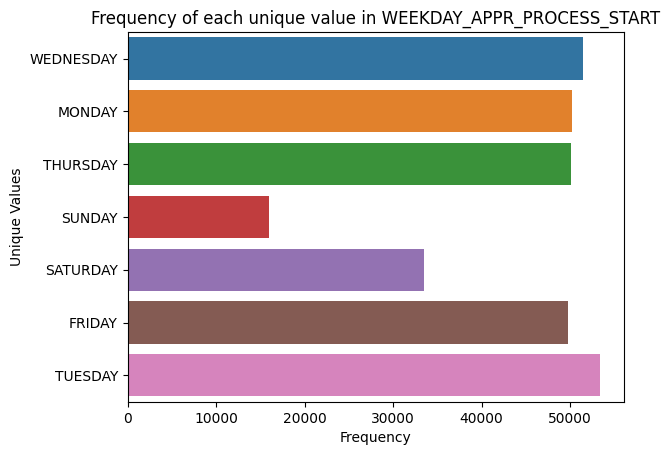

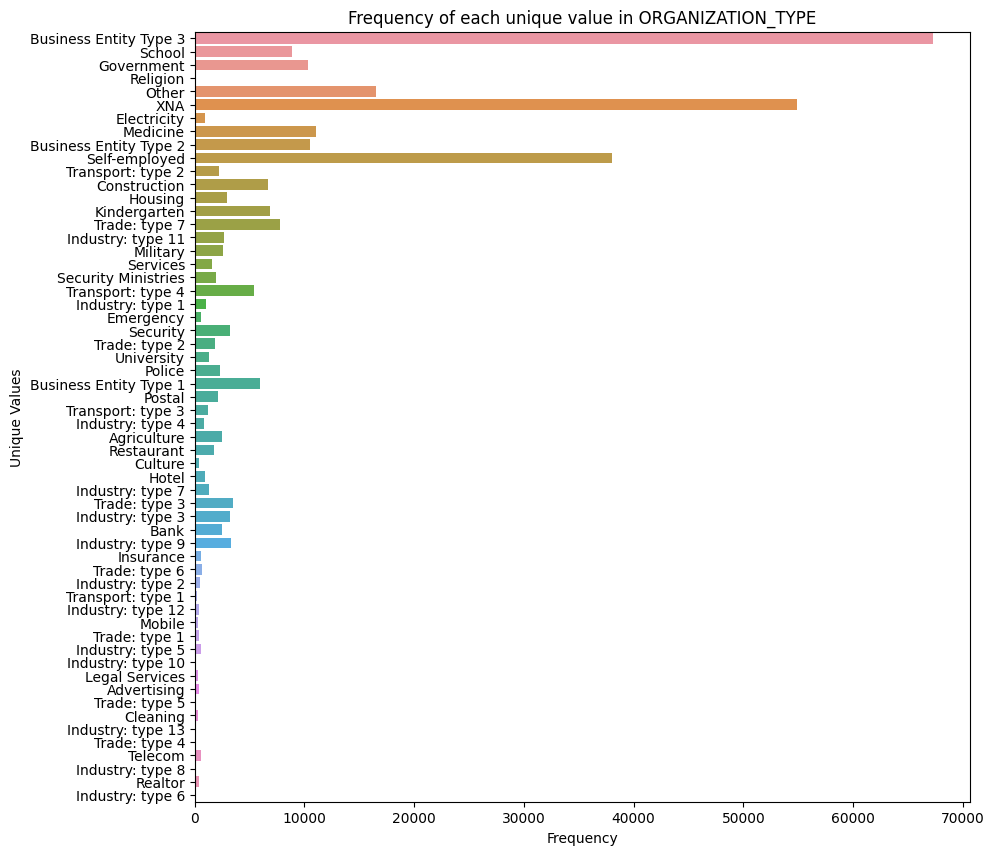

In [ ]:
# Visualising
for column in object_columns:
  if column in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']:
    plt.figure(figsize=(10, 10))
    plt.title(f"Frequency of each unique value in {column}")
    sns.countplot(y=clean_applications[column])
    plt.xlabel("Frequency")
    plt.ylabel("Unique Values")
    plt.show()
  else:
    plt.title(f"Frequency of each unique value in {column}")
    sns.countplot(y=clean_applications[column])
    plt.xlabel("Frequency")
    plt.ylabel("Unique Values")
    plt.show()


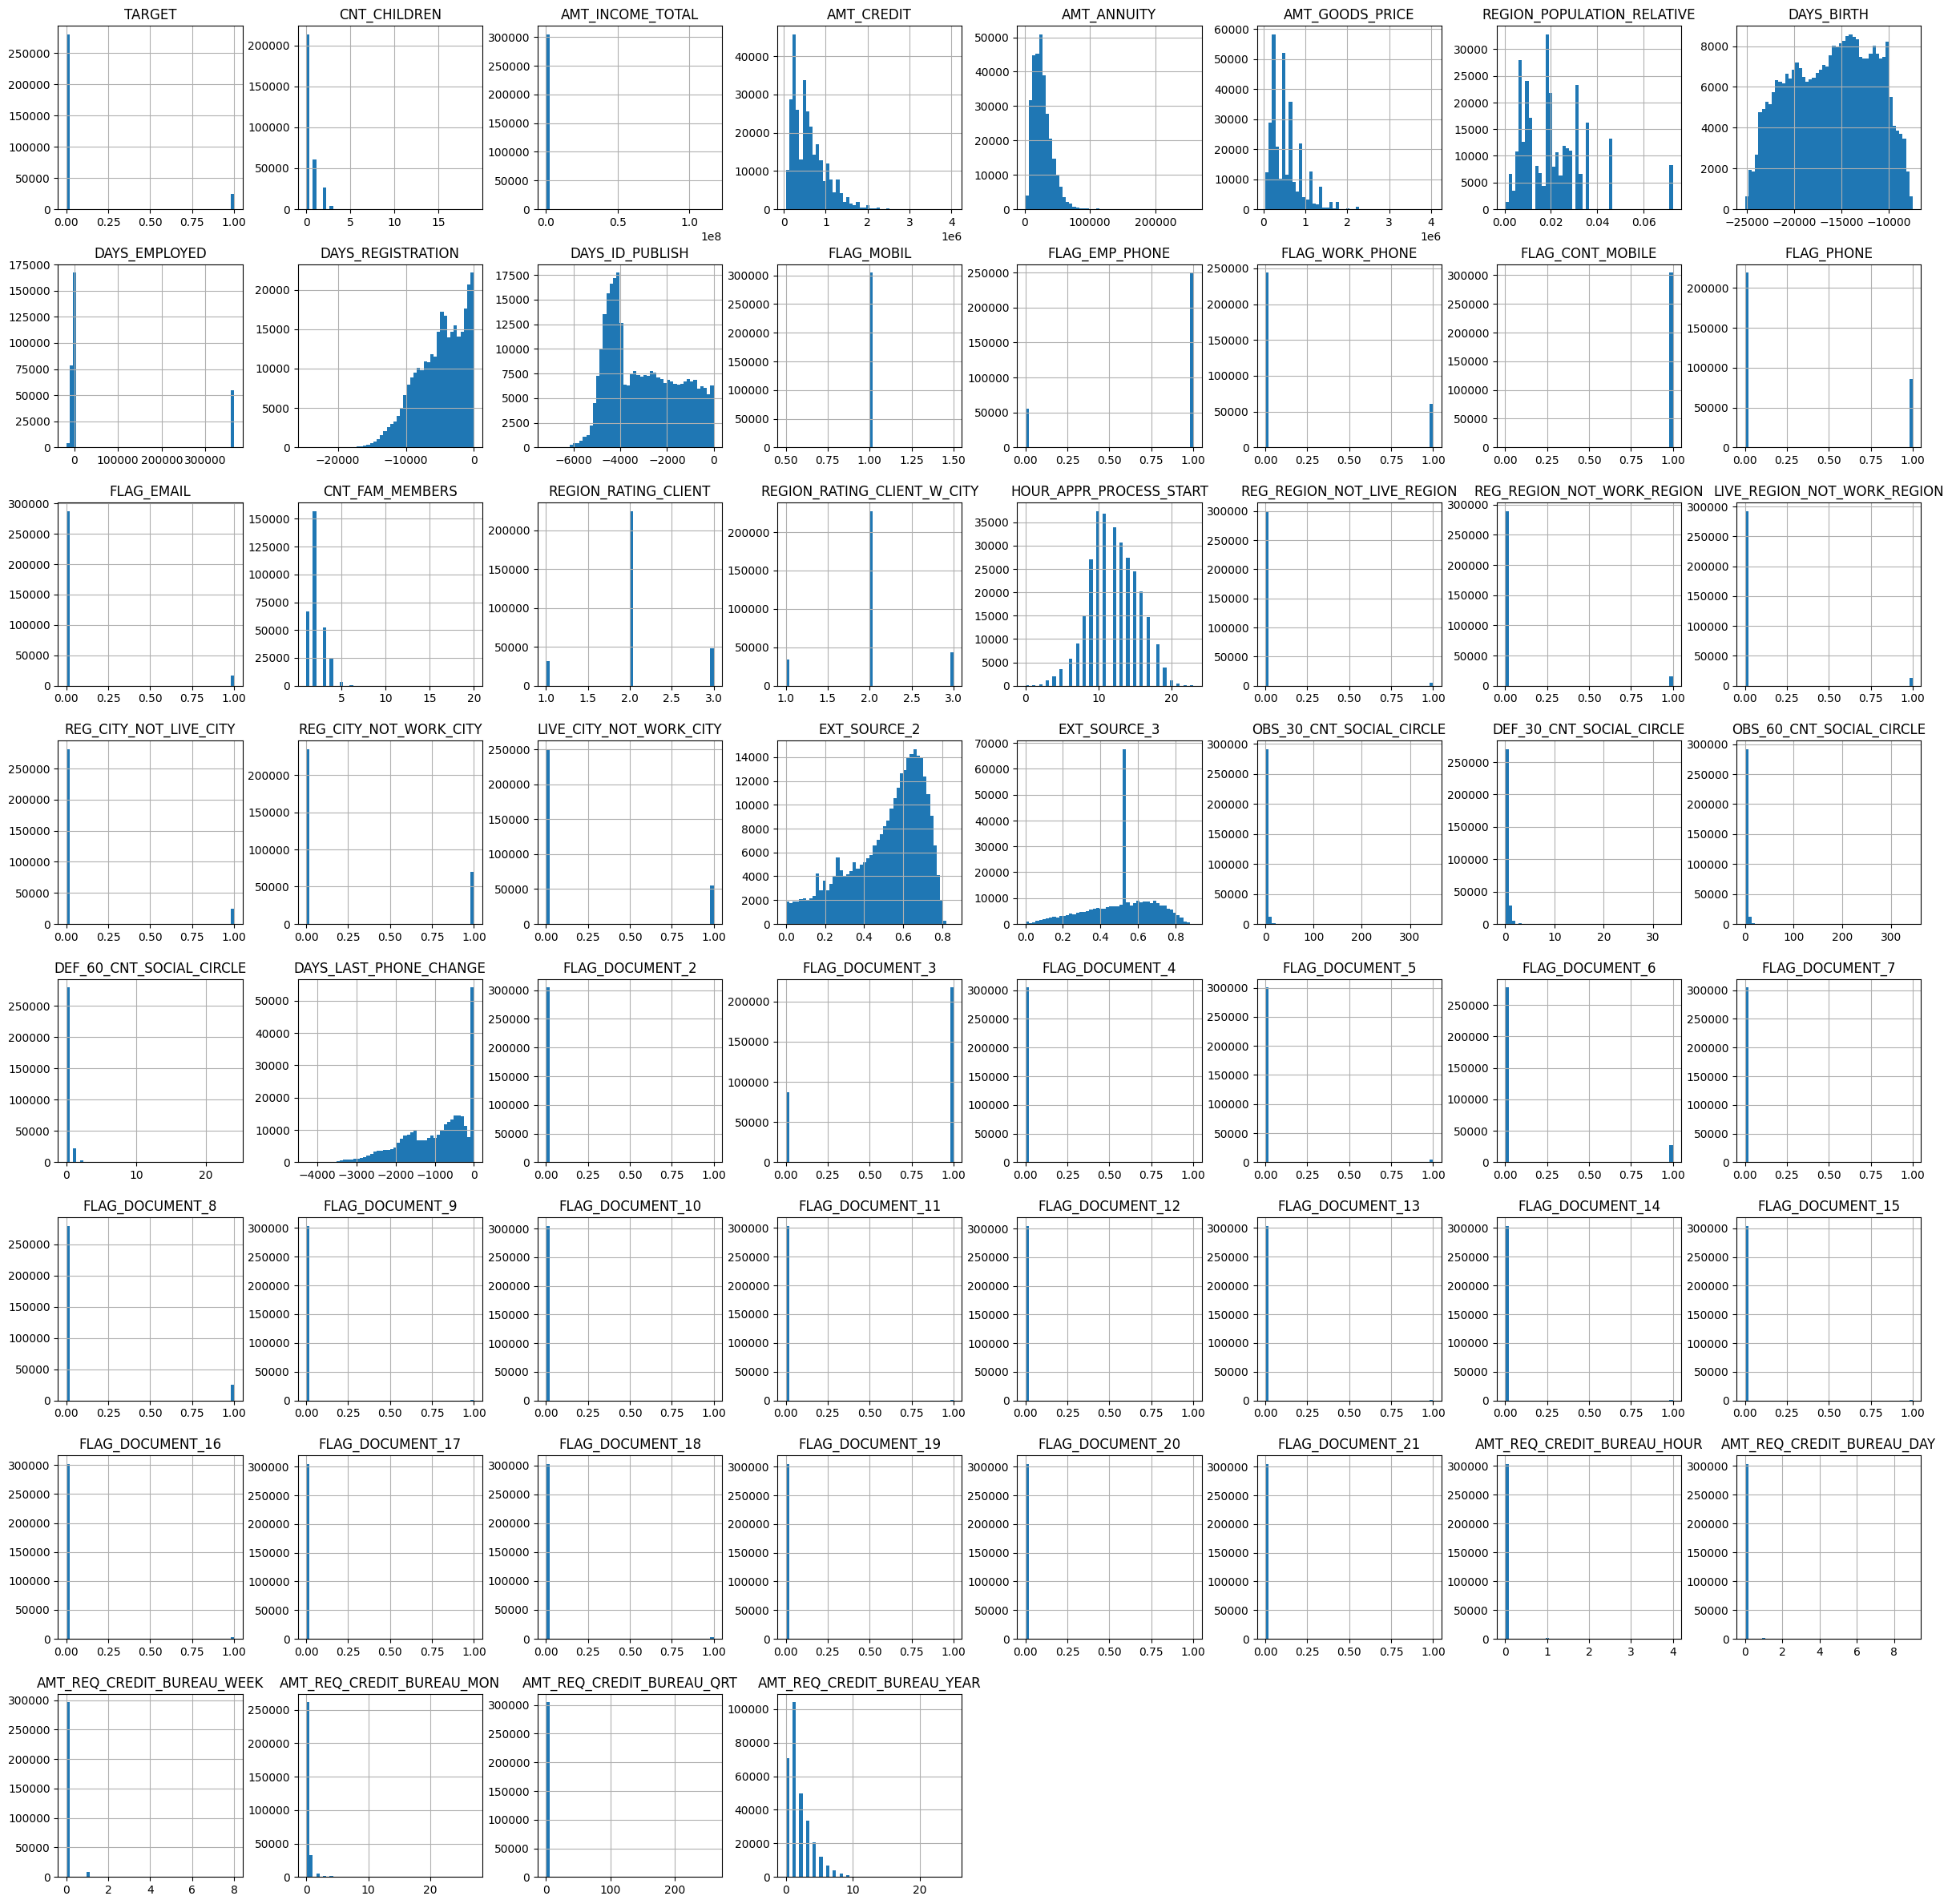

In [ ]:
# Creating a DataFrame of columns with the data type 'int64' or 'float64' from the 'clean_applications' DataFrame
numerical_columns = clean_applications.select_dtypes(include=['int64', 'float64'])

numerical_columns.hist(figsize=(30, 30), bins=50)
plt.show()


In [ ]:
# Removing XNA values in the CODE_GENDER feature as this does not seem to represent any valid values related to gender
clean_applications = clean_applications[clean_applications['CODE_GENDER'] != 'XNA']


In [ ]:
# Assigning ordinal values to the 'NAME_EDUCATION_TYPE' from the 'raw_applications' DataFrame
education_ordinal = {'Academic degree': 1, 'Higher education': 2, 'Incomplete higher': 3, 'Secondary / secondary special': 4, 'Lower secondary': 5}
clean_applications['NAME_EDUCATION_TYPE'] = clean_applications['NAME_EDUCATION_TYPE'].map(education_ordinal)

# Assigning binary values to the columns in the 'raw_applications' DataFrame that contain binary data
clean_applications['CODE_GENDER'].replace({'M': 1, 'F': 0}, inplace=True)
clean_applications['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)
clean_applications['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0}, inplace=True)


<ipython-input-24-3eb63ce4f531>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_applications['NAME_EDUCATION_TYPE'] = clean_applications['NAME_EDUCATION_TYPE'].map(education_ordinal)


In [ ]:
# Binning for OCCUPATION_TYPE and ORGANIZATION_TYPE to reduce dimensionality
default_rate_OCCUPATION_TYPE = clean_applications.groupby('OCCUPATION_TYPE')['TARGET'].mean()
default_rate_ORGANIZATION_TYPE = clean_applications.groupby('ORGANIZATION_TYPE')['TARGET'].mean()
default_rate_OCCUPATION_TYPE_bin = pd.cut(default_rate_OCCUPATION_TYPE, bins=4, labels=[4,3,2,1])
default_rate_ORGANIZATION_TYPE_bin = pd.cut(default_rate_ORGANIZATION_TYPE, bins=4, labels=[4,3,2,1])
clean_applications['ORGANIZATION_TYPE'].replace(default_rate_ORGANIZATION_TYPE_bin,inplace=True)
clean_applications['OCCUPATION_TYPE'].replace(default_rate_OCCUPATION_TYPE_bin, inplace=True)
# default_rate_ORGANIZATION_TYPE_bin_dict = default_rate_ORGANIZATION_TYPE_bin.to_dict()
#
# for i in clean_applications['ORGANIZATION_TYPE'].unique():
#     clean_applications.replace(i, default_rate_ORGANIZATION_TYPE_bin_dict[i], inplace=True)

# default_rate_OCCUPATION_TYPE_bin_dict = default_rate_OCCUPATION_TYPE_bin.to_dict()
#
# for i in clean_applications['OCCUPATION_TYPE'].unique():
#     clean_applications.replace(i, default_rate_OCCUPATION_TYPE_bin_dict[i], inplace=True)

# default_rate_OCCUPATION_TYPE_bin

# Accountants,4
# Secretaries,4
# Core staff,4
# Realty agents,4
# HR staff,4
# High skill tech staff,4
# IT staff,4
# Private service staff,4
# Medicine staff,4
# Managers,4
# Sales staff,3
# Laborers,3
# Security staff,3
# Cooking staff,3
# Cleaning staff,3
# Drivers,2
# Waiters/barmen staff,2
# Low-skill Laborers,1


# default_rate_ORGANIZATION_TYPE_bin

# XNA,4
# Military,4
# Police,4
# Industry: type 12,4
# Religion,4
# School,4
# Security Ministries,4
# University,4
# Trade: type 4,4
# Insurance,4
# Trade: type 5,4
# Trade: type 6,4
# Transport: type 1,4
# Culture,4
# Bank,4
# Trade: type 2,3
# Legal Services,3
# Medicine,3
# Transport: type 4,3
# Mobile,3
# Postal,3
# Transport: type 2,3
# Trade: type 7,3
# Telecom,3
# Trade: type 1,3
# Other,3
# Services,3
# Advertising,3
# Kindergarten,3
# Hotel,3
# Housing,3
# Industry: type 9,3
# Electricity,3
# Industry: type 10,3
# Government,3
# Business Entity Type 3,3
# Industry: type 11,3
# Industry: type 2,3
# Business Entity Type 1,3
# Industry: type 5,3
# Industry: type 6,3
# Industry: type 7,3
# Business Entity Type 2,3
# Emergency,3
# Cleaning,2
# Construction,2
# Agriculture,2
# Industry: type 8,2
# Industry: type 1,2
# Security,2
# Restaurant,2
# Realtor,2
# Industry: type 3,2
# Industry: type 4,2
# Trade: type 3,2
# Self-employed,2
# Industry: type 13,1
# Transport: type 3,1


### 3.2 Outliers handling
Investigating and handling outliers using visual and non-visual methods

In [ ]:
#Define function to filter out numeric outliers using z_score
def filter_outliers(col, threshold=3):
    if col.name in [i for i in list(numerical_columns.columns) if i != 'TARGET']:
        z_scores = np.abs(col - col.mean()) / col.std()
        col_copy = col.copy()  #Create a copy of the column to avoid modifying the original
        col_copy[z_scores >= threshold] = col.mean() + threshold * col.std()  #Replace outliers on positive side
        col_copy[z_scores <= -threshold] = col.mean() - threshold * col.std()  #Replace outliers on negative side
        return col_copy
    else:
        return col
#Filter out only numeric col
clean_applications = clean_applications.apply(filter_outliers, axis=0)


### 3.3 Encoding categorical data

In [ ]:
# Creating a DataFrame of columns with the data type 'object' from the 'clean_applications' DataFrame
object_columns = clean_applications.select_dtypes(include=['object'])

#
object_columns_value_counts = object_columns.apply(lambda c: c.value_counts().to_dict())


In [ ]:
# Creating dummy variables for categorical columns
clean_applications = pd.get_dummies(clean_applications, columns=object_columns.columns)


## 4. Feature Engineering

We will try to make a few new features from the traditionally important features in the dataset. The features that we will use as input will include:
+ **EXT_SOURCE_1/2/3**: Normalized score from external data source 1,2,3 - We dropped the EXT_SOURCE_1 due to the feature was missing over 50%
+ AMT_ANNUITY: Loan annuity
+ AMT_CREDIT: Credit amount of the loan
+ AMT_INCOME_TOTAL: Income of the client
+ AMT_GOODS_PRICE: For consumer loans it is the price of the goods for which the loan is given
+ DAYS_EMPLOYED: How many days before the application the person started current employment
+ CNT_FAM_MEMBERS: How many family members does client have
+ DAYS_EMPLOYED: How many days before the application the person started current employment
+ DAYS_BIRTH: Client's age in days at the time of application

Explaining the engineered features:
1. EXT_MEAN/EXT_STD: not everyone have their profiles at all 3 external sources, hence by aggregating from multiple sources we will be able to build a more in-depth understanding of the individual - Even though we remove EXT_SOURCE_1 due to excessive missing values, by incoporating the data into the engineered features we can still retain this knowledge
2. GOOD_CREDIT: How much was the purchase financed by credit
3. ANNUITY_INCOME: How much of the customer's income will be spend on paying back for the loan
4. CREDIT_INCOME: The size of the credit compare to the customer's income
5. CNT_FAM_INCOM: The total income divided by the size of family - so a person cam have a high personal income buy a bigger size family may suggest more or less level of expenses
6. INCOME_EMPLOYED: The ratio between level of income comparing to level of work experience. Someone can be incredibly young but they may have a level of income excedding their peers
7. INCOME_BIRTH: The ratio between level of income comparing to actual age - Elder citizen may have substantial personal saving but lack thereoff may indicate a much dire situation


In [ ]:
#Engineering key features from the applications dataset
def engineered_apps(data, raw):

    data['EXT_MEAN'] = raw[[ 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    data['EXT_STD'] = raw[[ 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    data['EXT_STD'] = data['EXT_STD'].fillna(data['EXT_STD'].median())
    data['GOODS_CREDIT'] = raw['AMT_GOODS_PRICE']/raw['AMT_CREDIT']
    data['ANNUITY_INCOME'] = raw['AMT_ANNUITY']/raw['AMT_INCOME_TOTAL']
    data['CREDIT_INCOME'] = raw['AMT_CREDIT']/raw['AMT_INCOME_TOTAL']
    data['CNT_FAM_INCOME'] = raw['AMT_INCOME_TOTAL']/raw['CNT_FAM_MEMBERS']
    data['INCOME_EMPLOYED'] = raw['AMT_INCOME_TOTAL']/raw['DAYS_EMPLOYED']
    data['INCOME_BIRTH'] = raw['AMT_INCOME_TOTAL']/raw['DAYS_BIRTH']

    return data

clean_applications = engineered_apps(clean_applications, raw_applications)


### 4.1 Handling infinity values

In [ ]:
# Check for infinity
is_infinity = clean_applications.isin([float("inf"), float("-inf")])


# Identify columns with infinity
columns_with_infinity = is_infinity.any()

print("Columns with infinity:")
print(clean_applications.loc[:,columns_with_infinity].columns)


Columns with infinity:
Index(['INCOME_EMPLOYED'], dtype='object')


In [ ]:
# Name of the column with infinity values
column_name = 'INCOME_EMPLOYED'
clean_applications = clean_applications[~np.isinf(clean_applications[column_name])]


## 5. Scaling the dataset

Since we already remove outlier in section 3 so we could use minmaxscaler or StandardScaler without worry about outlier skewing the result. Since our features have different units so we will go with StandardScaler. This choice also consider the implementation of Kmean-clustering in the unsupervised portion

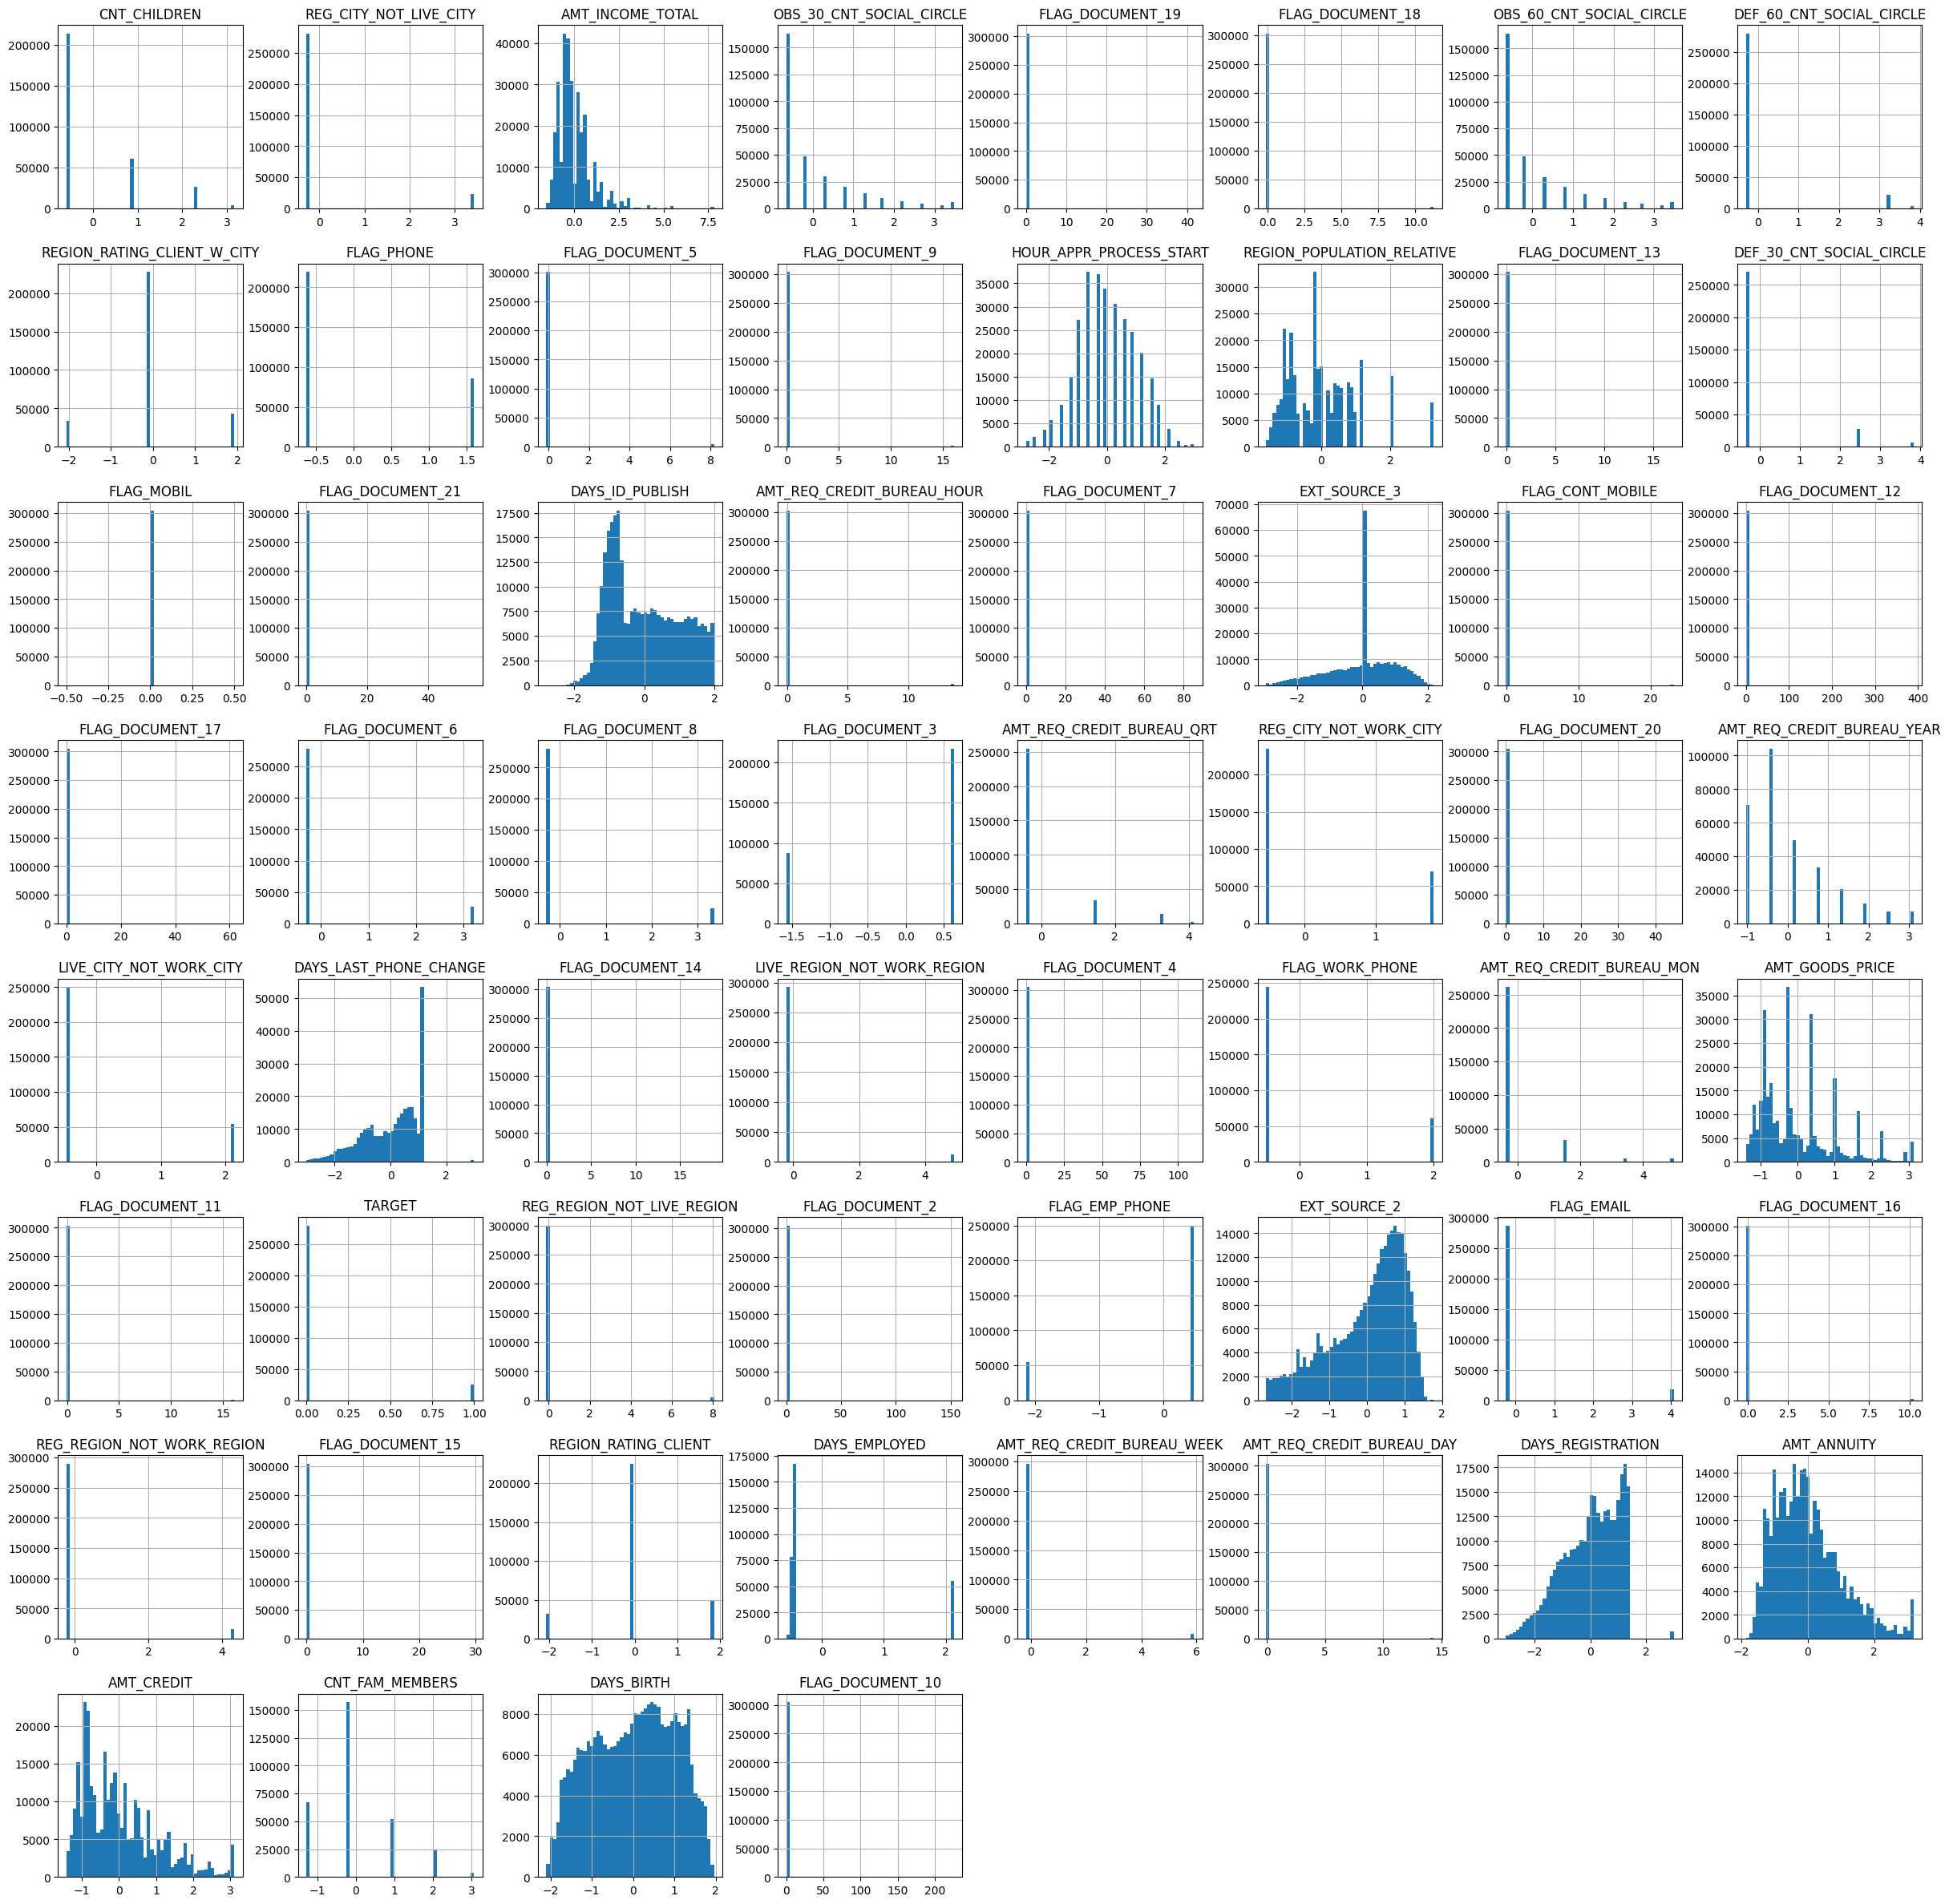

In [ ]:
#Splitting the dataset into dependent and independent
clean_applications_independent = copy.deepcopy(clean_applications.drop('TARGET', axis= 1))
clean_target = clean_applications['TARGET']


# Scaled the data using the MinMax method
scaler = StandardScaler()
scaler.fit(clean_applications_independent)

# Scale only the data part
df_scaled = scaler.transform(clean_applications_independent)

# Merging to make a clean DataFrame with 'TARGET' included
df_clean = pd.DataFrame(df_scaled, columns=clean_applications.columns[1:,])
df_clean['TARGET'] = clean_target.reset_index(drop=True)  # Reset the index to ensure proper alignment


# Graph the numerical col to see the distribution after scaling
numerical_columns_raw = raw_applications.select_dtypes(include=['int64', 'float64']).columns
numerical_columns_clean = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Find the common numerical columns
common_numerical_columns = list(set(numerical_columns_raw) & set(numerical_columns_clean))
# Creating a DataFrame of columns with the data type 'int64' or 'float64' from the 'clean_applications' DataFrame
numerical_columns = df_clean[common_numerical_columns]

numerical_columns.hist(figsize=(30, 30), bins=50)
plt.show()


In [ ]:
# Calculate the total number of plots
total_plots = numerical_columns.shape[1]

# Divide the plot into rows of 5
num_cols = 5
num_rows = int(total_plots / num_cols)

# Create a figure and set size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Create boxplot and place them
for i, column in enumerate(numerical_columns.columns):
    ax = axes[i // num_cols, i % num_cols]  # Select the appropriate subplot
    ax.boxplot(numerical_columns[column], vert=False)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)

# Remove empty subplots
for i in range(total_plots, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()


## 6. Post Cleaning Visualization

### 6.1 Feature grouping

In [ ]:
# Grouping features into categories to assist with visualization
feature_categories = {
    'document_flag': [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',],
    'client_personal': [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
    'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE',
    'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
    'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Widow', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_BIRTH'],
    'credit': [
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_CONTRACT_TYPE_Cash loans',
    'NAME_CONTRACT_TYPE_Revolving loans', 'GOODS_CREDIT', 'ANNUITY_INCOME',
    'CREDIT_INCOME', 'CNT_FAM_INCOME', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_MEAN', 'EXT_STD'],
    'contact': [
    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
    'FLAG_PHONE', 'FLAG_EMAIL', 'DAYS_LAST_PHONE_CHANGE'],
    'employment': [
    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OCCUPATION_TYPE',
    'INCOME_EMPLOYED', 'INCOME_BIRTH', 'ORGANIZATION_TYPE'],
    'address': [
    'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment',
    'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment',
    'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents'],
    'application': [
    'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY',
    'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
    'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY']
}

# Creating a function to plot feature importance

def plot_all_feature_importance(df, name):
    features = df.drop(columns=['TARGET']).columns
    correlate = df[features].join(df['TARGET']).corr()['TARGET'].drop('TARGET')
    sorted_features = correlate.sort_values(ascending=False)
    top_features = sorted_features.head(15)
    plt.figure(figsize=(10, 12))
    sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm_r")
    plt.title(f'Feature Importance for {name}')
    plt.xlabel('Correlation Coefficient')
    plt.show()


### 6.2 Interrelationship visualization

In [ ]:
# document flag features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['document_flag']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Document Flag Features')
plt.show()


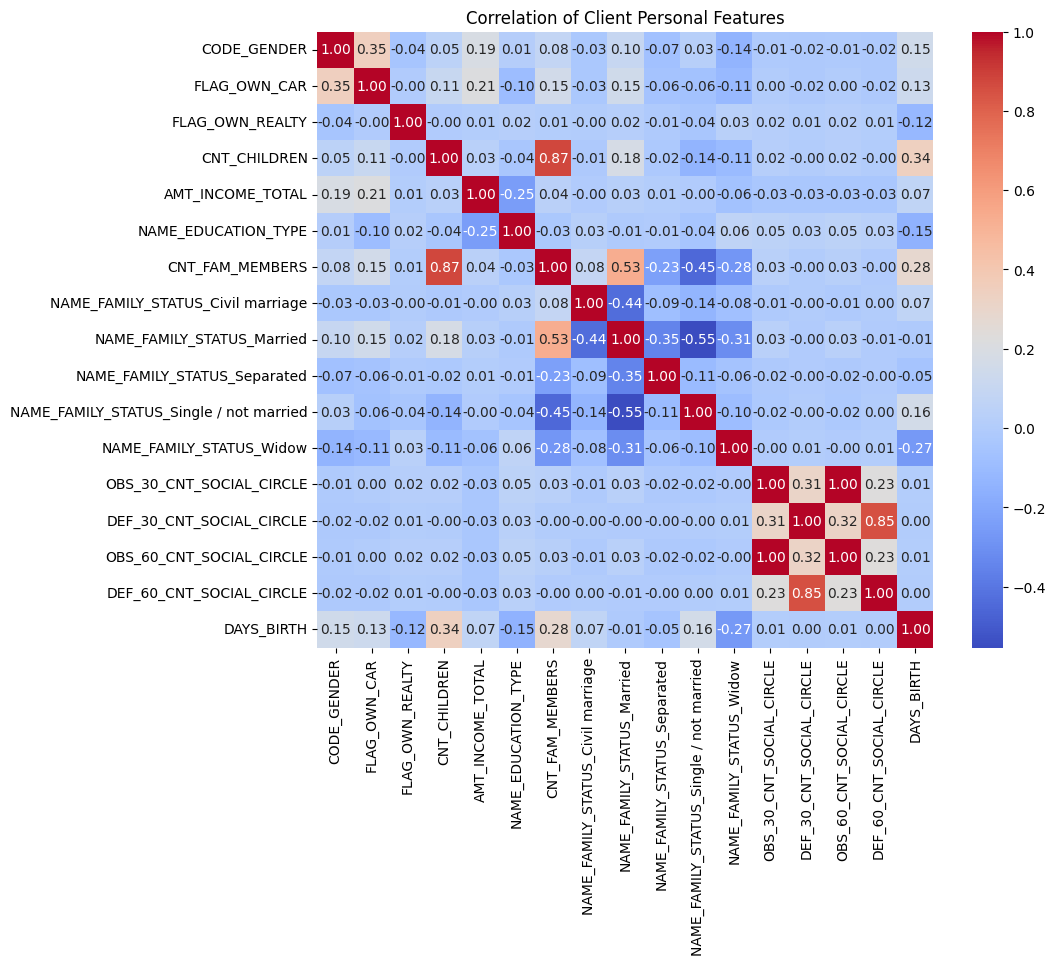

In [ ]:
# client personal features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['client_personal']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Client Personal Features')
plt.show()


In [ ]:
# credit features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['credit']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Credit Features')
plt.show()


In [ ]:
# contact features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['contact']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Contact Features')
plt.show()


In [ ]:
# employment features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['employment']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Employment Features')
plt.show()


In [ ]:
# address features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['address']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Address Features')
plt.show()


In [ ]:
# application features heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[feature_categories['application']].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Application Features')
plt.show()


### 6.3 Feature Importance

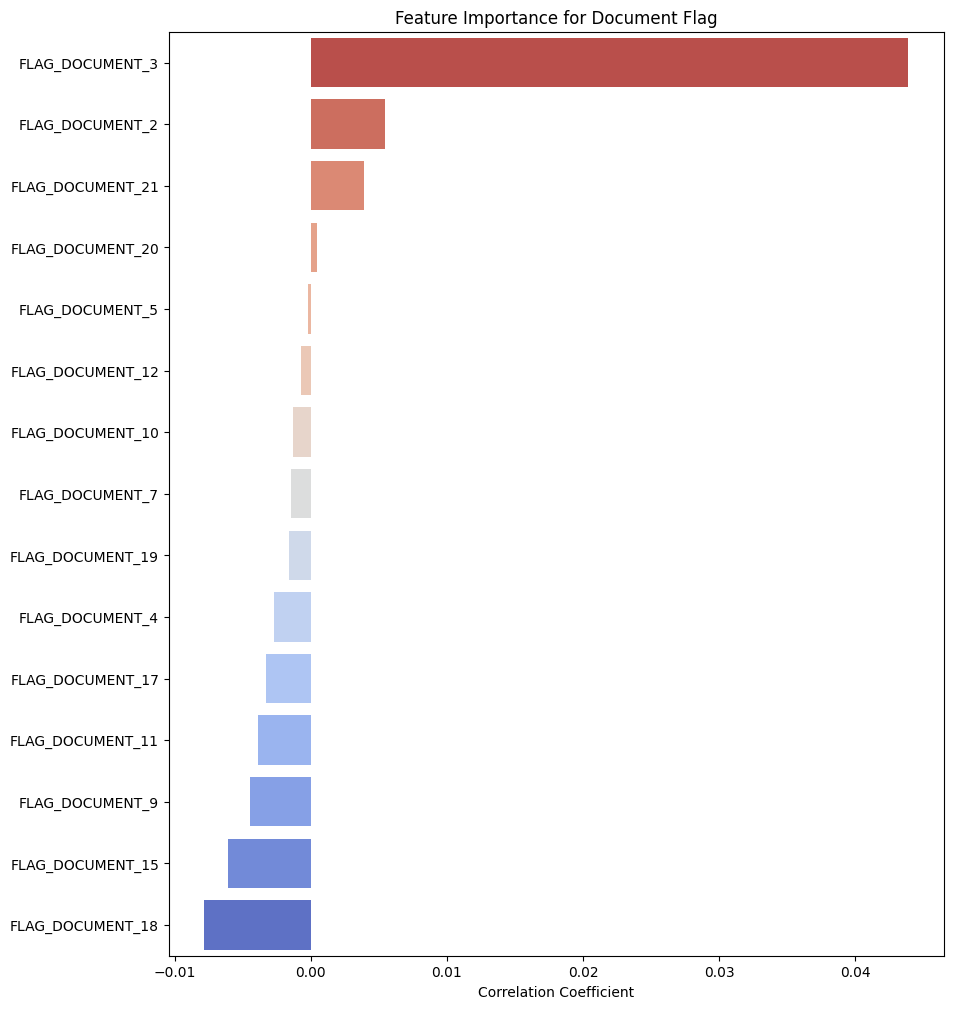

In [ ]:
# Document flag features
feature_categories['document_flag'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['document_flag']], 'Document Flag')


In [ ]:
# Client personal features
feature_categories['client_personal'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['client_personal']], 'Client Personal')


In [ ]:
# Credit features
feature_categories['credit'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['credit']], 'Credit')


In [ ]:
# Contact flag features
feature_categories['contact'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['contact']], 'Credit')


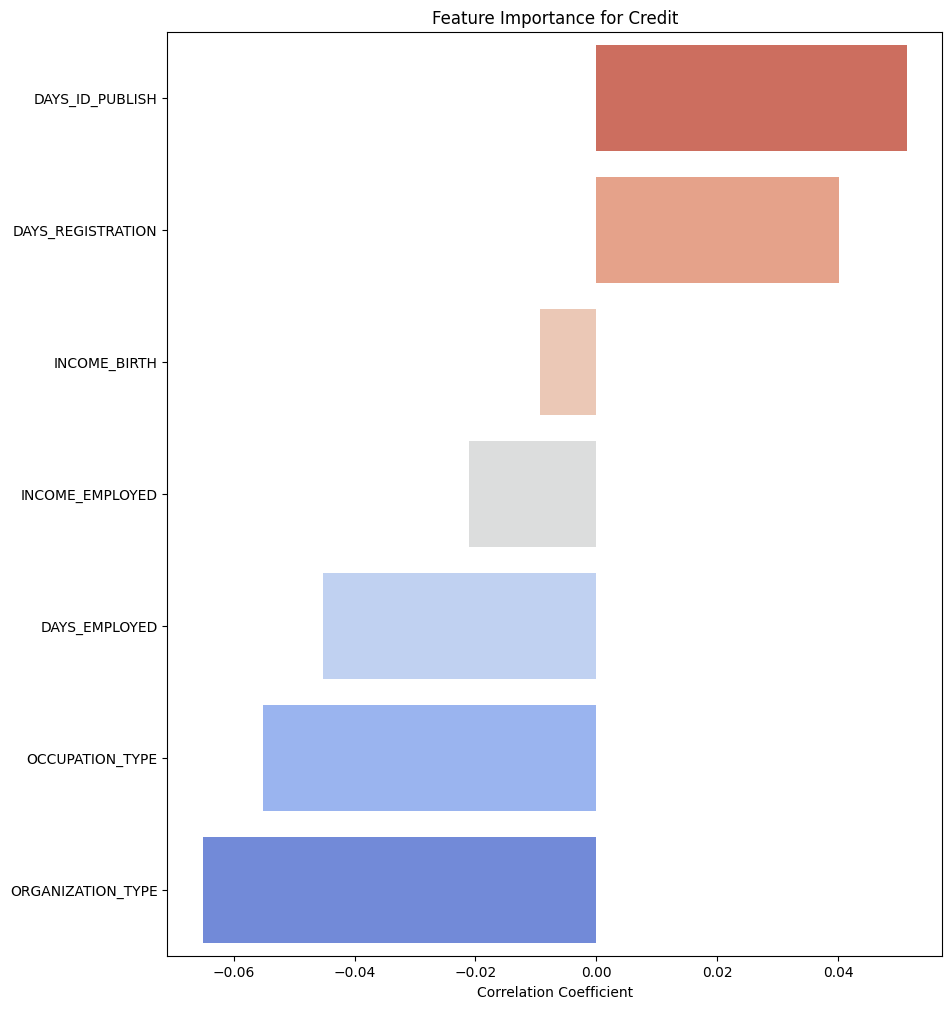

In [ ]:
# Employment features
feature_categories['employment'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['employment']], 'Credit')


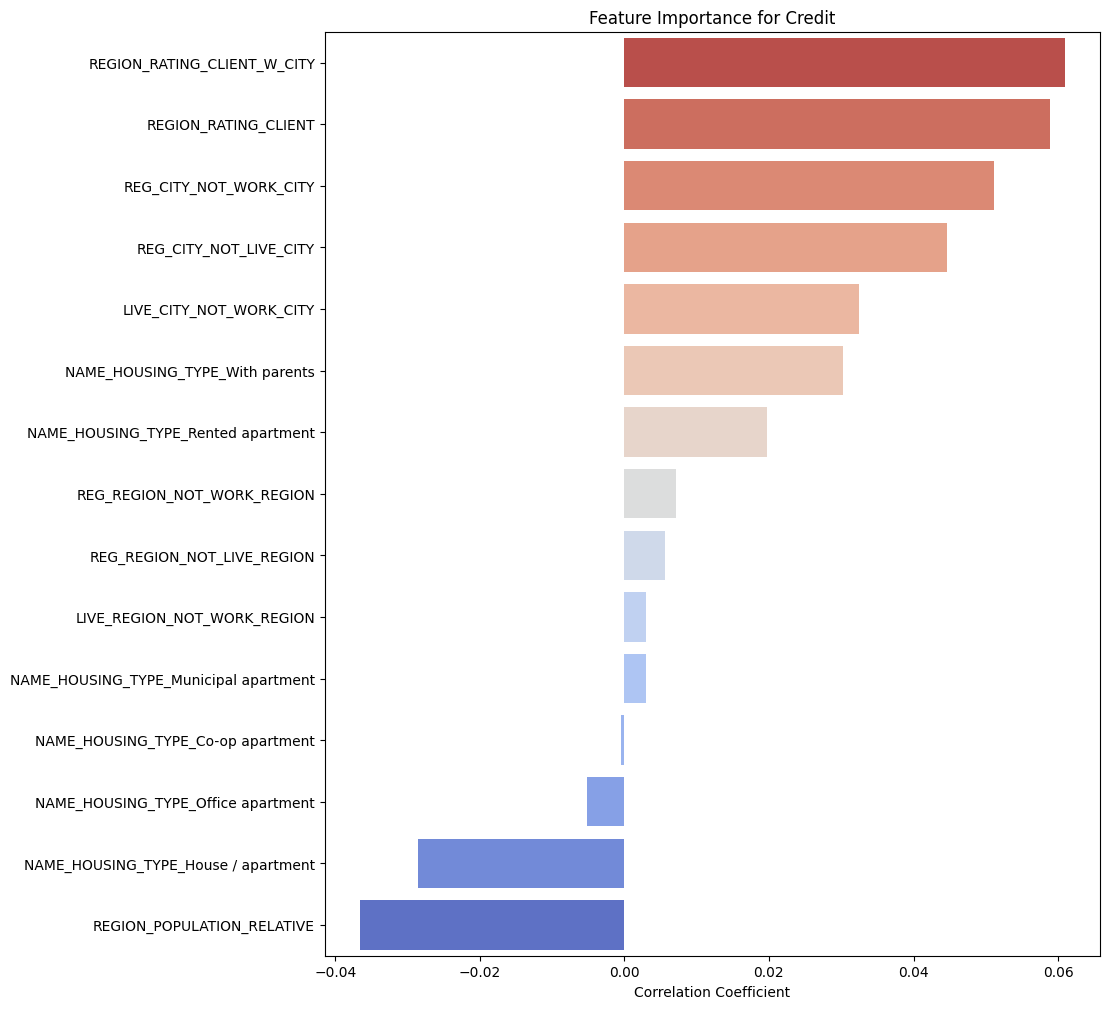

In [ ]:
# Address flag features
feature_categories['address'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['address']], 'Credit')


In [ ]:
# Application flag features
feature_categories['application'].append('TARGET')
plot_all_feature_importance(df_clean[feature_categories['application']], 'Credit')


## 7. Unsupervised learning

Performing unsupervised learning on the full dataset may be very computationally intenseive so we will just try to explore on a small subset

In [ ]:
#Running k-mean clustering on the whole dataframe might be too heavy so we will choose most correlated features only
correlations = df_clean.corr()['TARGET'].abs().sort_values(ascending=False)

#Taking the top most correlated features, excluding the TARGET feature itself
top_15_correlated = correlations[1:16].index.tolist()

#Extract the corresponding columns from the DataFrame
df_top15 = df_clean[top_15_correlated]

In [ ]:
df_top15.isnull().sum()

Observing the most correlated features with TARGET, we observe a few details:
1. EXT_MEAN is better than the individual EXT_SOURCE 2,3 so it would seem the engineered feature helps
2. DAYS_BIRTH is the next most correlated feature (we will use this for the unsupervised portion)
3. After cleaning and reformat, ORGANIZATION_TYPE and OCCUPATION_TYPE has a better correlation with TARGET
4. REGION_RATIN_CLIEANT_W_CITY and REGION_RATING_CLIENT are relatively high and would suggest to further experimental to remove certain discrimination in the lending process

In [ ]:
3# Drawing a heat map of correlation between TARGET and the top 15 features
plt.figure(figsize = (15, 10))
target_corr = df_clean[correlations[:16].index.tolist()].corr() #including TARGET too
sns.heatmap(target_corr, annot = True)
plt.title('Correlation of Top Features')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[correlations[1:16].index.tolist()].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Top Features')
plt.show()

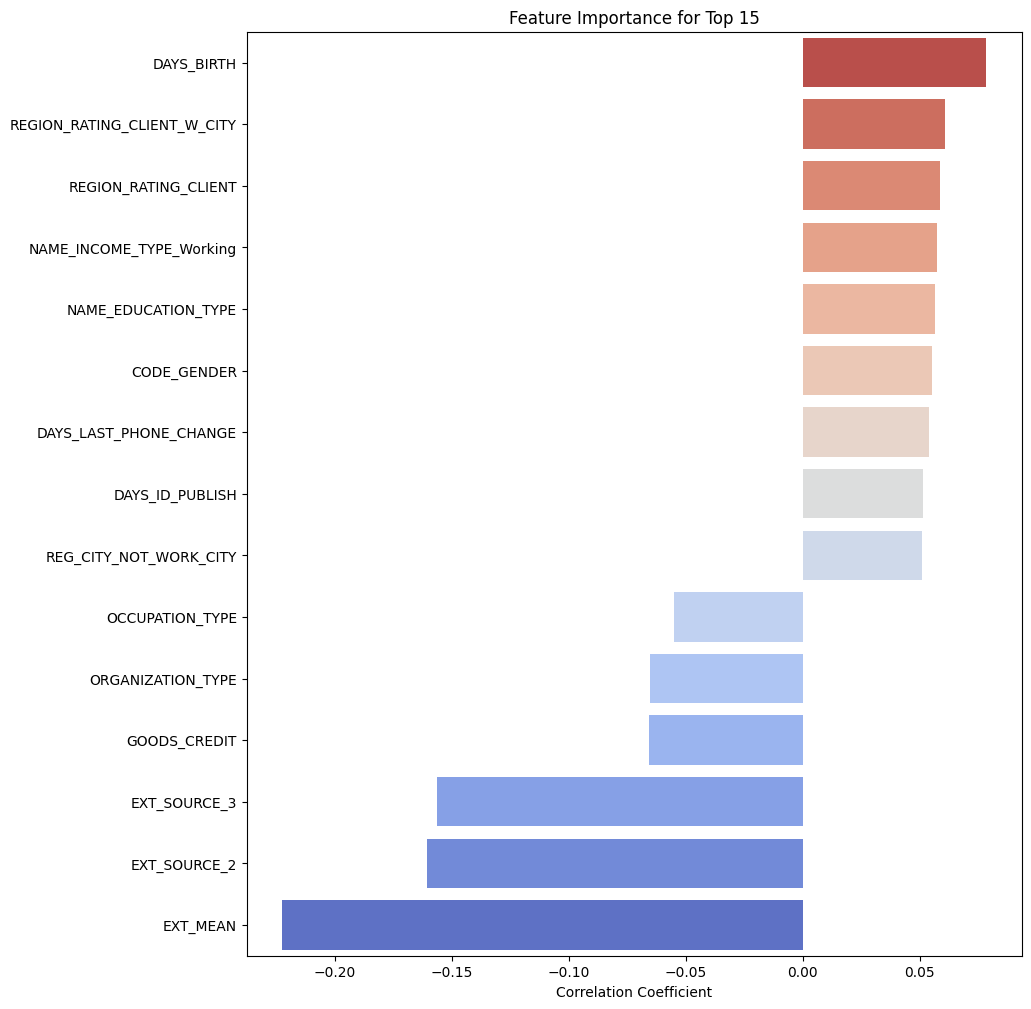

In [ ]:
# Top 15 features
feature_categories['application'].append('TARGET')
plot_all_feature_importance(df_clean[correlations[:16].index.tolist()], 'Top 15')

We are dealing with a binary classification problem so we already expect there to be 2 cluster in the dataset. So now we will perform K-means unsupervised learning on the dataset at 3 different level of detail of the dataset:
- Full features
- Using top 15 most correlated features to TARGET
- Using only 2 most correlated features to TARGET: EXT_MEAN and DAYS_BIRTH
and then cross-reference with the actual TARGET value to see if there exist any visible distinction.

In the case of using all features and 15 features, we will also ultilize PCA to find a simpler 2D representation of the clusters.
Since the size of the dataset is relatively big so we will create a sample using random undersampler for a faster calculation

In [ ]:
#Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=20)
x_sample = df_clean.drop('TARGET', axis=1)
y_sample = df_clean['TARGET']

#Perform undersampling
x_sample, y_sample = undersampler.fit_resample(x_sample, y_sample)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


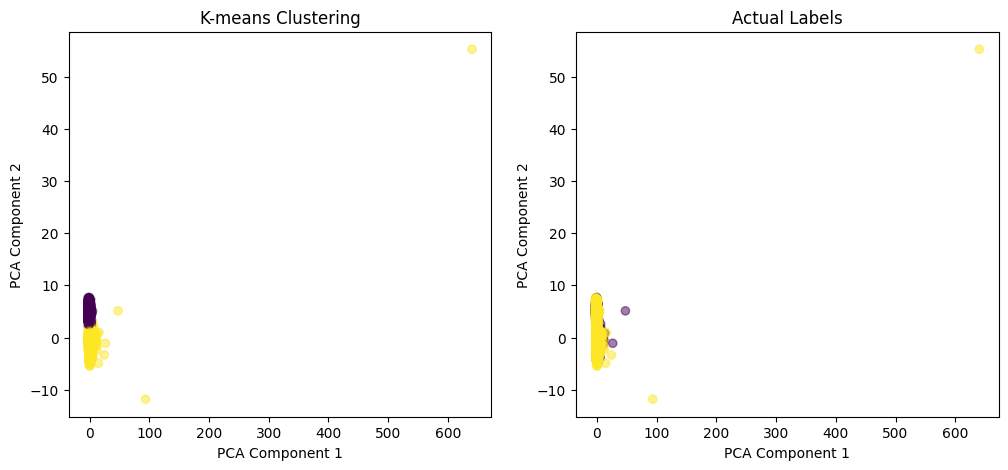

Completeness score 0.00912230891098369
Homogeneity score 0.005612057874697564


In [ ]:
#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_sample)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(x_sample)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')

# Subplot 2: Actual Labels
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=  y_sample, alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('PCA Component 1')
axs[1].set_ylabel('PCA Component 2')
plt.show()
#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

In [ ]:
sample_top15 =  x_sample[top_15_correlated]

#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(sample_top15)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(sample_top15)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')

# Subplot 2: Actual Labels
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=  y_sample, alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('PCA Component 1')
axs[1].set_ylabel('PCA Component 2')
plt.show()

#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

In [ ]:
sample_top2 =  x_sample[['EXT_MEAN', 'DAYS_BIRTH']]

#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(sample_top2)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(sample_top2['EXT_MEAN'], sample_top2['DAYS_BIRTH'], c= kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('EXT_MEAN')
axs[0].set_ylabel('DAYS_BIRTH')

# Subplot 2: Actual Labels
axs[1].scatter(sample_top2['EXT_MEAN'], sample_top2['DAYS_BIRTH'], c=  y_sample, cmap='viridis', alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('EXT_MEAN')
axs[1].set_ylabel('DAYS_BIRTH')

plt.show()
#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

In close inspection of the 3 different visualization, there does not seem to be clear distinction between TARGET = 0 and 1.
For a good clustering result, we would want a completeness and homogeinity score as close to 1 as possible. But in reality, our clusters never score above 0.1
Also the clusters using all the available features perform significantly poorer comparing to when we are just using the top 15 or 2 features

## 8. Supervised learning

### 8.1 Running the dataset as they are

For the Supervised Learning portion, we will use the confusion matrix to measure performance of different algorithm. In addition, we will also be using ROC AUC score for reference as this is the official measurement for the Home Credit competition

In [ ]:
import time

# Creating a function for validating
def scoring(df,target, classifier, res, label):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, target, test_size=0.30)
  lm = classifier
  start_time = time.perf_counter()
  lm.fit(X_train, Y_train)
  lm.predict_proba(X_test)
  predicted = lm.predict(X_test)
  end_time = time.perf_counter()
  # Print Confusion Matrix
  confusionMatrix = metrics.confusion_matrix(Y_test, predicted)
  print(confusionMatrix)
  # The confusion matrix showing percentages of each group
  ax = sns.heatmap(confusionMatrix / np.sum(confusionMatrix), annot=True, fmt='.2%', cmap='Blues')
  plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
  plt.xlabel('Predicted values', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('True values', fontsize = 15) # y-axis label with fontsize 15
  plt.show()
  # Print Classification Report
  # Calculate the ROC AUC
  roc_auc = roc_auc_score(Y_test, predicted)
  print(metrics.classification_report(Y_test, predicted))
  print(f'ROC AUC Score: {roc_auc:.2f}')
  res[label] = roc_auc
  # Calculate elapsed time
  elapsed_time = end_time - start_time
  print("Elapsed time: ", elapsed_time)
  return res,lm

In [ ]:
#Define a res to capture auc score from different model
res = {}

For this part, we will just use Logistic Regression as a bench mark as it is relatively simple to interpret the result and is computationlly efficient.

[[83857    56]
 [ 7358    87]]


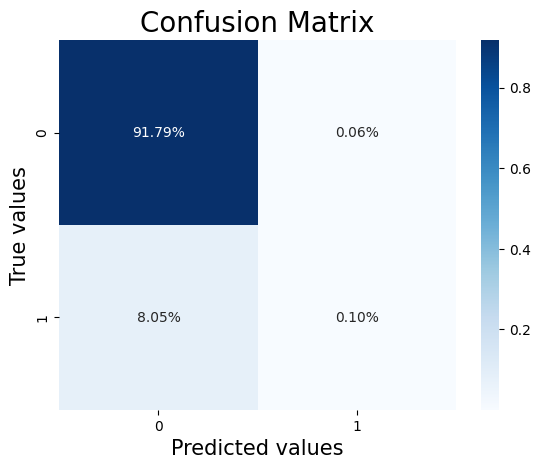

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83913
           1       0.61      0.01      0.02      7445

    accuracy                           0.92     91358
   macro avg       0.76      0.51      0.49     91358
weighted avg       0.89      0.92      0.88     91358

ROC AUC Score: 0.51
Elapsed time:  27.319419673000084


({'logistic_df_clean': 0.505509168619323}, LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_df_clean'
scoring(df_scaled,clean_target, LogisticRegression(max_iter=5000), res, label)

We understand that for a binary classification, there exist only 2 possible choices. By default, if we just randomly guess, we would have a 50-50 chance. The same is happening here, the model using the data got a ROC AUC score of 0.51, essentially equal to randomly leave things for chances.
The model compeletely fail because the data is severely skewed toward TARGET = 0.
Intuitively think about this phenomenon, since the majority of the values are = 0, so the model automatically get a good accuracy just guessing **EVERYONE** as TARGET = 0, or will not default. To mitigate this problem, we have a few approach, including undersampling and oversampling to make the count of the 2 value type approximately equal to each other

### 8.2 Adjusting the dataset using oversampling

In [ ]:
#Splitting the dataset into the independent and dependent features
X = df_clean.drop('TARGET', axis=1)
y = df_clean['TARGET']

#Preparing the oversampler
oversampler = RandomOverSampler(random_state=42)

#creating the over samples for X and y
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

[[57808 26243]
 [27012 56853]]


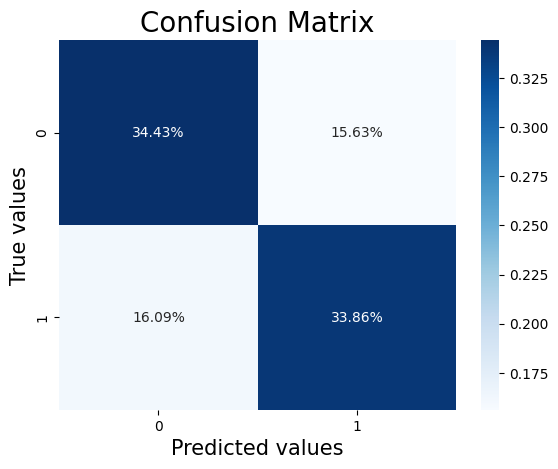

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     84051
           1       0.68      0.68      0.68     83865

    accuracy                           0.68    167916
   macro avg       0.68      0.68      0.68    167916
weighted avg       0.68      0.68      0.68    167916

ROC AUC Score: 0.68
Elapsed time:  68.51342850899891


({'logistic_df_clean': 0.505509168619323,
  'logistic_oversampled': 0.6828419140323115},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_oversampled'
scoring(X_oversampled, y_oversampled, LogisticRegression(max_iter=5000),res, label)

### 8.3 Adjusting the dataset using undersampling

In [ ]:
#Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

#Perform undersampling
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

[[5048 2322]
 [2376 5054]]


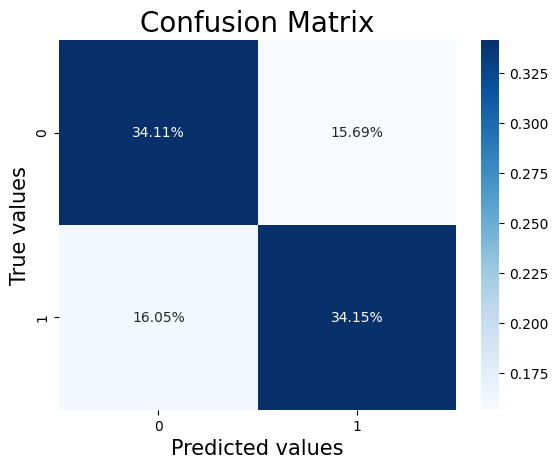

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      7370
           1       0.69      0.68      0.68      7430

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  2.7514196510001057


In [ ]:
label = 'logistic_undersampled'
res, logistic_model= scoring(X_undersampled,y_undersampled,LogisticRegression(max_iter=5000), res, label)

<Axes: title={'center': 'Feature importances in Logistic Classifier'}, ylabel='Feature'>

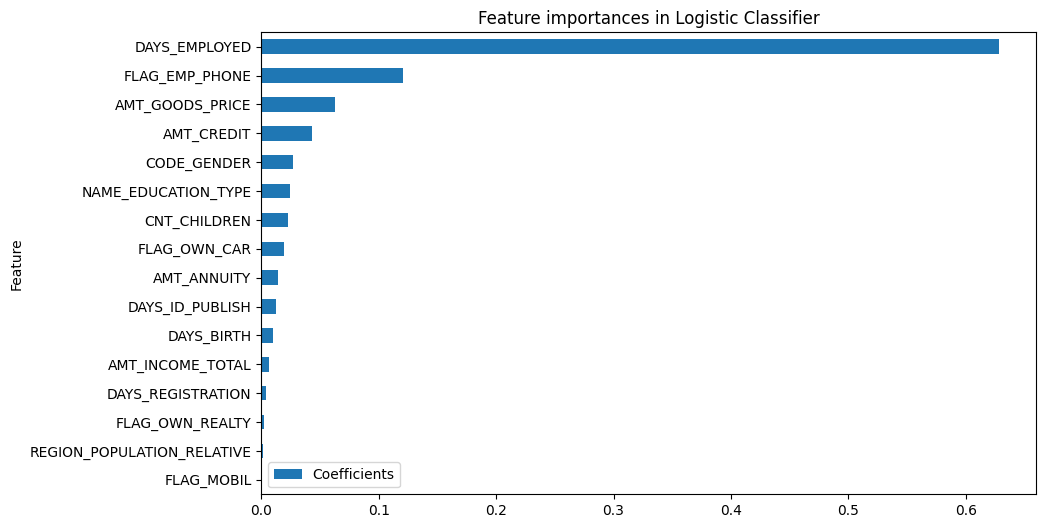

In [ ]:
#Visualizing feature importances
coefficients = logistic_model.coef_[0][0:16]
coefficient = abs(coefficients) / sum(abs(coefficients))
feature_importance = pd.DataFrame({'Feature': df_clean.columns[0:16], 'Coefficients': np.abs(coefficient)})
feature_importance = feature_importance.sort_values('Coefficients', ascending=True)
feature_importance.plot(x='Feature', y='Coefficients', kind='barh', figsize=(10, 6), title ='Feature importances in Logistic Classifier')

Here we observe that both undersampling and oversampling return a relatively better result comparing to the first attempt. This happened because we have provide to the model enough samples of both type for the model to learn and thus have a relatively differentiation power.

### 8.4 Transforming the dataset via polynomial features

In [ ]:
#Select the top 15 most correlated columns (excluding 'TARGET' itself)
top_15_correlated = correlations[1:16].index.tolist()

#Extract the corresponding columns from the DataFrame
df_top15 = X_undersampled[top_15_correlated]

#Transformign the dataset via polynomial features
poly_engineer = PolynomialFeatures(degree = 3)
poly_engineer = poly_engineer.fit(df_top15)
train_poly_fea_15 = poly_engineer.transform(df_top15)

[[5040 2355]
 [2439 4966]]


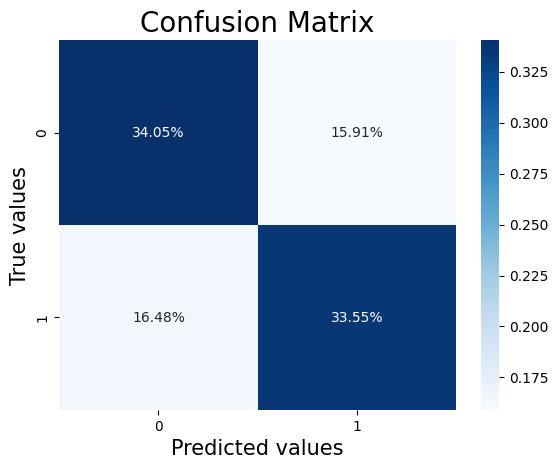

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      7395
           1       0.68      0.67      0.67      7405

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  77.76684922200002


({'logistic_df_clean': 0.5052406669311746,
  'logistic_oversampled': 0.6827465109937686,
  'logistic_undersampled': 0.684276558449503,
  'logistic_poly': 0.6760847681175896},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_poly'
scoring(train_poly_fea_15, y_undersampled, LogisticRegression(max_iter=5000),res ,label)

In case the relationship between the TARGET and rest of the feature is not linear but exhibits a more complex, non-linear pattern, we could consider raising the current dataset to a specified degree

### 8.5 Trying with different supervised ML method

From the above datasets, we observed that undersampling help improve the F1 score while maintaining a small size. So from now we will be using the undersampled dataset with different supervised machine learning methods to see if there is any improvement


#### Decision Tree

[[4295 3085]
 [3115 4305]]


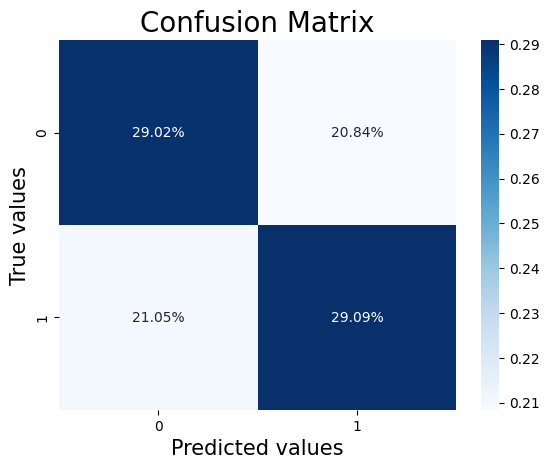

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      7380
           1       0.58      0.58      0.58      7420

    accuracy                           0.58     14800
   macro avg       0.58      0.58      0.58     14800
weighted avg       0.58      0.58      0.58     14800

ROC AUC Score: 0.58
Elapsed time:  1.667919586000039


In [ ]:
label = 'tree_undersampled'
res, tree_model = scoring(X_undersampled, y_undersampled, DecisionTreeClassifier(),res, label)

<Axes: title={'center': 'Feature importances in Decision Tree'}>

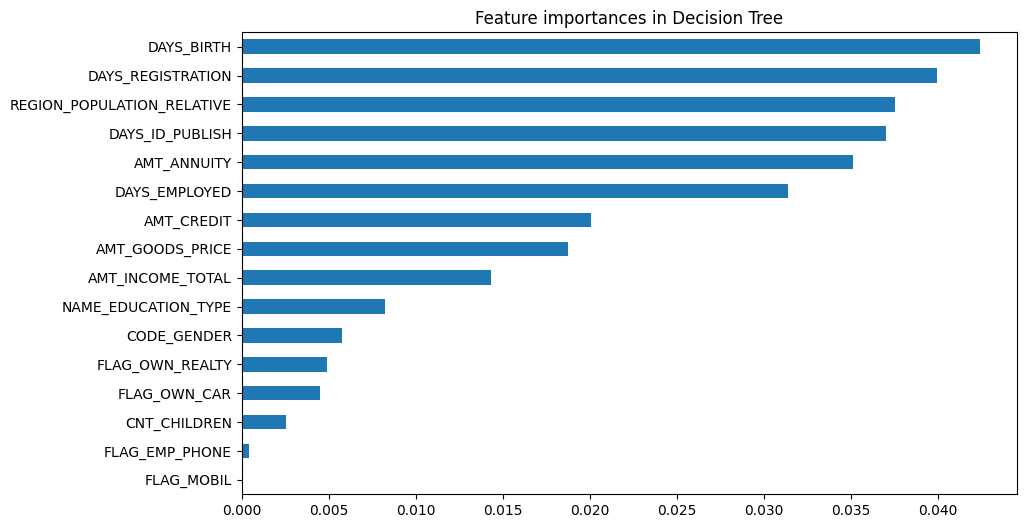

In [ ]:
#Visualizing Feature importances
feature_imp = pd.Series(tree_model.feature_importances_[0:16], index= df_clean.columns[0:16]).sort_values(ascending=True)

feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = 'Feature importances in Decision Tree')

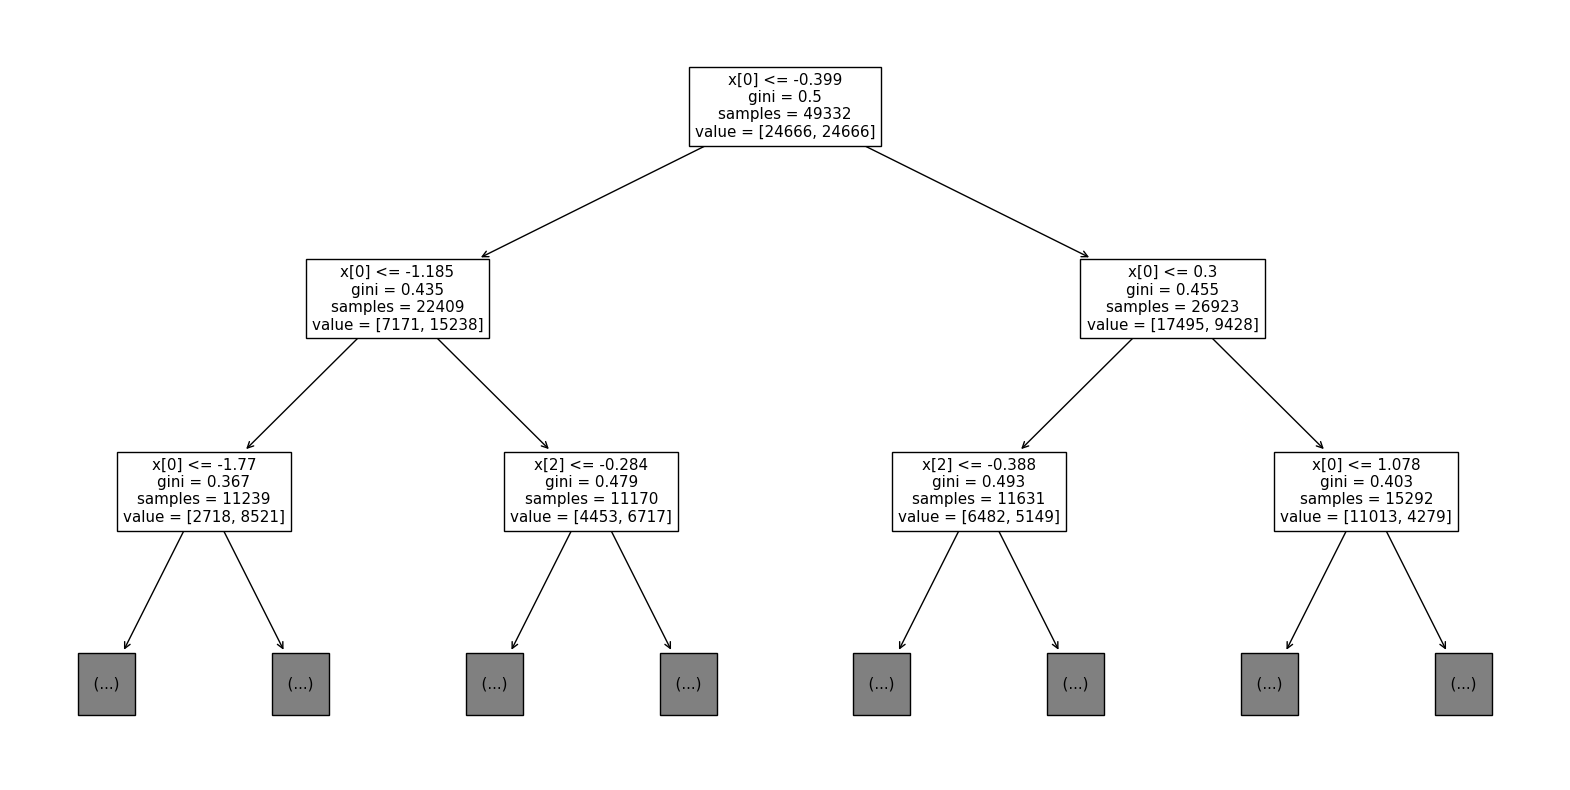

In [ ]:
from sklearn import tree
tree_sample = X_undersampled[['EXT_MEAN', 'DAYS_BIRTH', 'GOODS_CREDIT']]
model = DecisionTreeClassifier()
clf = model.fit(tree_sample, y_undersampled)
plt.figure(figsize=(20, 10))
tree.plot_tree(clf,max_depth = 2)
plt.show()

Decision Trees are good when interpretability is a primary concern and when we need a simple model to understand the decision-making process.
It is also possible to visualize the tree as shown on the above visualization

#### K-Neighbors

[[4405 2935]
 [3011 4449]]


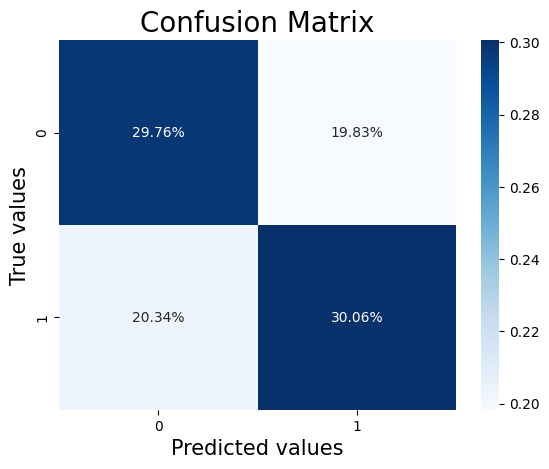

              precision    recall  f1-score   support

           0       0.59      0.60      0.60      7340
           1       0.60      0.60      0.60      7460

    accuracy                           0.60     14800
   macro avg       0.60      0.60      0.60     14800
weighted avg       0.60      0.60      0.60     14800

ROC AUC Score: 0.60
Elapsed time:  13.59549759500004


({'logistic_df_clean': 0.5052406669311746,
  'logistic_oversampled': 0.6827465109937686,
  'logistic_undersampled': 0.684276558449503,
  'logistic_poly': 0.6760847681175896,
  'tree_undersampled': 0.5810834995142404,
  'KNN_undersampled': 0.5982584684164773},
 KNeighborsClassifier())

In [ ]:
label = 'KNN_undersampled'
scoring(X_undersampled,y_undersampled, KNeighborsClassifier(),res,label)

K-NN is sensitive to the scale of features, and wwith increasing number of features, the calculation process could increase exponentially as the distance metric increase. K-NN is also subseptible to imbalance dataset, such as the one we are working on.

#### Gaussian NB

[[4962 2439]
 [2808 4591]]


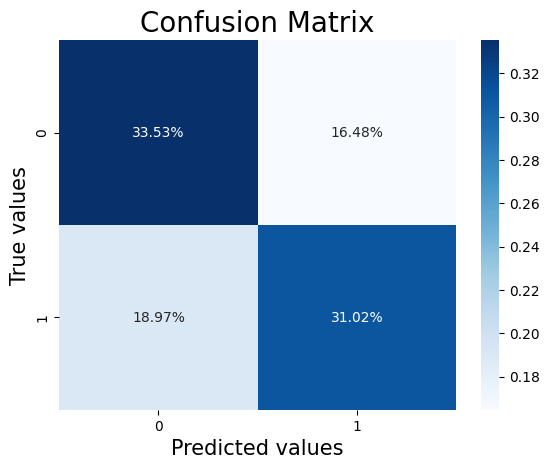

              precision    recall  f1-score   support

           0       0.64      0.67      0.65      7401
           1       0.65      0.62      0.64      7399

    accuracy                           0.65     14800
   macro avg       0.65      0.65      0.65     14800
weighted avg       0.65      0.65      0.65     14800

ROC AUC Score: 0.65
Elapsed time:  0.10792326799997909


({'logistic_df_clean': 0.5052406669311746,
  'logistic_oversampled': 0.6827465109937686,
  'logistic_undersampled': 0.684276558449503,
  'logistic_poly': 0.6760847681175896,
  'tree_undersampled': 0.5810834995142404,
  'KNN_undersampled': 0.5982584684164773,
  'Gaussian_undersampled': 0.6454695972510883},
 GaussianNB())

In [ ]:
label = 'Gaussian_undersampled'
scoring(X_undersampled,y_undersampled,GaussianNB(),res,label)

So far this method has yield the worst result yet. There might be a few potential reasons for it:
1. The "Naive" in Naive Bayes refers to the assumption of feature independence. It assumes that each feature is independent of all others, But from the correlate heat map we create above, we have many features that are correlated or dependent on each other.
2. Distribution Assumptions: Gaussian Naive Bayes assumes that the features follow a Gaussian (normal) distribution. Since we already scaled the dataset using Standard scaler so we could expect somewhat better result but a lot of the feature may not be inhenrenly normally distributed

#### Random Forest

[[5142 2180]
 [2542 4936]]


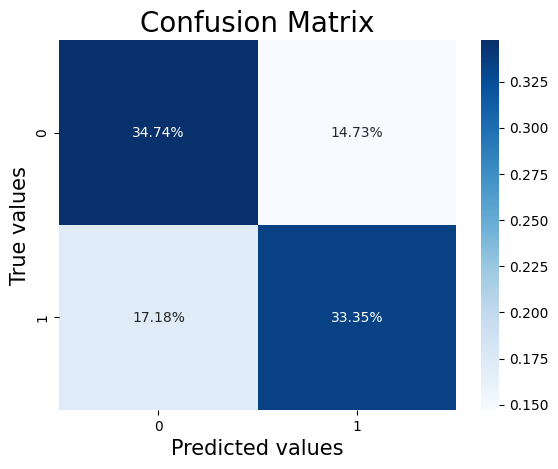

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      7322
           1       0.69      0.66      0.68      7478

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  15.04727088200002


In [ ]:
label = 'RandomForest_undersampled'
model = RandomForestClassifier(n_estimators=100, random_state=10)
res, forest_model = scoring(X_undersampled,y_undersampled,model,res,label)

<Axes: title={'center': 'Feature importances in Random Forest'}>

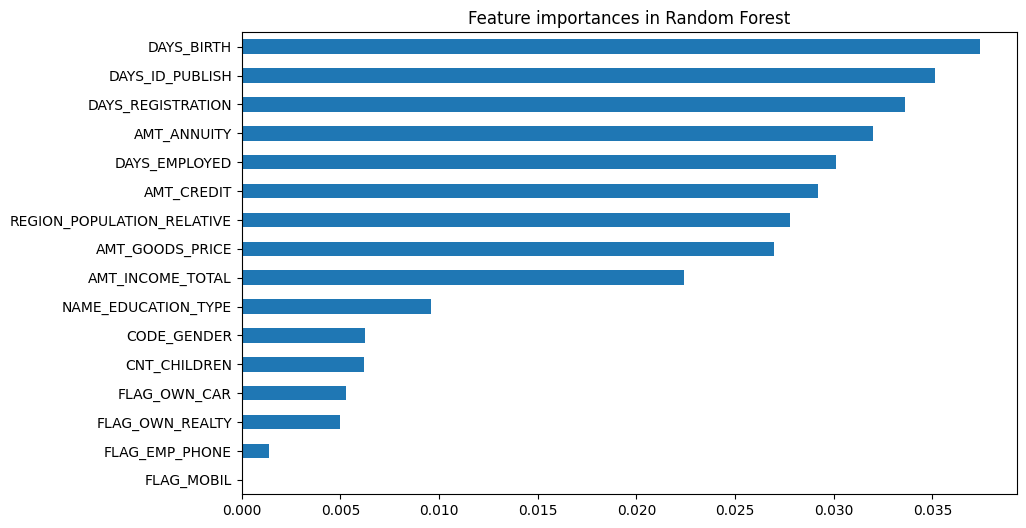

In [ ]:
#Visualizing features importances
feature_imp = pd.Series(forest_model.feature_importances_[0:16], index= df_clean.columns[0:16]).sort_values(ascending=True)

feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = 'Feature importances in Random Forest')

Compare to decision tree, RandomForest is a ensemble learning method that combines multiple decision trees to produce a more robust and accurate model.

### 8.6 Removing the ext_source features

In [ ]:
#Removing features related to external sources, including EXT_SOURCE_1/2/3 and engineered features
#Defining col to drop
columns_to_drop = [col for col in X_undersampled.columns if col.startswith("EXT")]

#Create a copy
X_remove_ext = X_undersampled.drop(columns=columns_to_drop)

[[4698 2635]
 [2786 4681]]


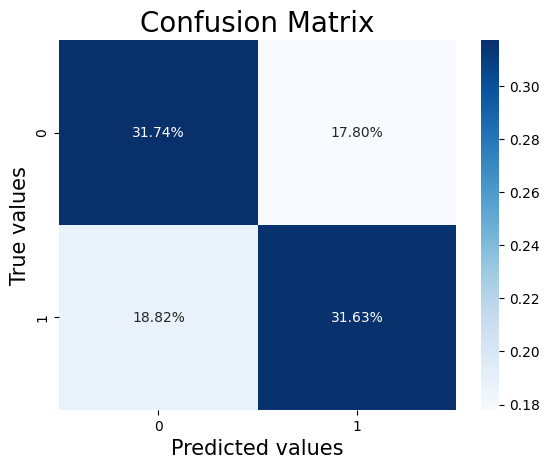

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      7333
           1       0.64      0.63      0.63      7467

    accuracy                           0.63     14800
   macro avg       0.63      0.63      0.63     14800
weighted avg       0.63      0.63      0.63     14800

ROC AUC Score: 0.63
Elapsed time:  4.830623496999976


({'logistic_df_clean': 0.5052406669311746,
  'logistic_oversampled': 0.6827465109937686,
  'logistic_undersampled': 0.684276558449503,
  'logistic_poly': 0.6760847681175896,
  'tree_undersampled': 0.5810834995142404,
  'KNN_undersampled': 0.5982584684164773,
  'Gaussian_undersampled': 0.6454695972510883,
  'RandomForest_undersampled': 0.6811683387175449,
  'logistic_minus_ext': 0.6337785707086178},
 LogisticRegression(max_iter=1000))

In [ ]:
label = 'logistic_minus_ext'
scoring(X_remove_ext, y_undersampled, LogisticRegression(max_iter=1000), res, label)

### 8.7 Removing features relating to addresses/postcodes

In [ ]:
#Removing features related to external sources, including EXTERNA_SOURCE_1/2/3 and engineered features
#Create a copy
X_remove_address = X_undersampled.drop(columns=['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

[[5114 2340]
 [2364 4982]]


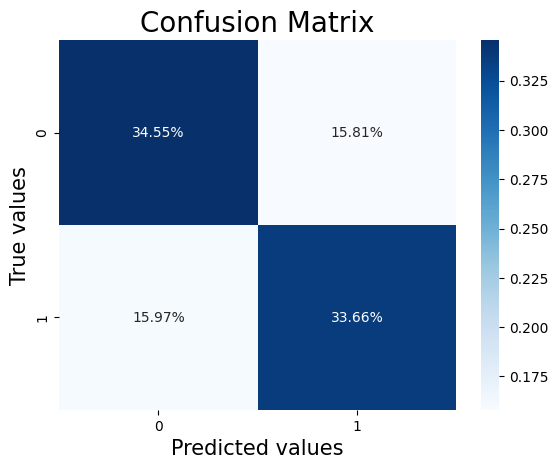

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      7454
           1       0.68      0.68      0.68      7346

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  2.7191180440000267


({'logistic_df_clean': 0.5052406669311746,
  'logistic_oversampled': 0.6827465109937686,
  'logistic_undersampled': 0.684276558449503,
  'logistic_poly': 0.6760847681175896,
  'tree_undersampled': 0.5810834995142404,
  'KNN_undersampled': 0.5982584684164773,
  'Gaussian_undersampled': 0.6454695972510883,
  'RandomForest_undersampled': 0.6811683387175449,
  'logistic_minus_ext': 0.6337785707086178,
  'logistic_minus_address': 0.6821334021366076},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_minus_address'
scoring(X_remove_address, y_undersampled, LogisticRegression(max_iter=5000), res, label)

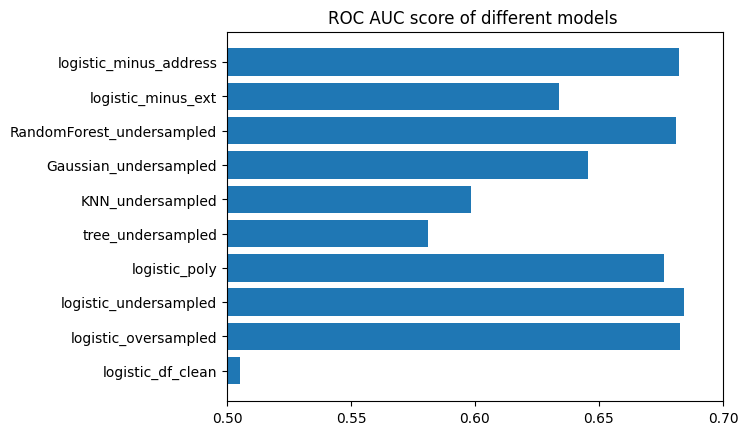

In [ ]:
plt.barh(list(res.keys()), [val - 0.5 for val in list(res.values())], left = 0.5)
plt.title('ROC AUC score of different models ')
plt.xticks([0.5,0.55,0.6,0.65,0.7])
plt.show()

In [ ]:
import re
X_undersampled.columns = [re.sub(r'\W+', '_', col) for col in X_undersampled.columns]

In [ ]:
from sklearn.model_selection import train_test_split
Z = X_undersampled
Y = y_undersampled
Z_DEV, Z_TEST, Y_DEV, Y_TEST = train_test_split(Z, Y, test_size = 0.1, random_state = 0)
Z_TRAIN, Z_VAL, Y_TRAIN, Y_VAL = train_test_split(Z_DEV, Y_DEV, test_size = 0.2, random_state = 0)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [ ]:
clf = LGBMClassifier(
            n_estimators=4000, # Number of boosted trees to fit (default=100)
            learning_rate=0.01, # Boosting learning rate (default=0.1)
            max_depth = 11, # Maximum tree depth for base learners, <=0 means no limit (default=-1)
            num_leaves=58, # Maximum tree leaves for base learners (default=31)
            colsample_bytree=0.613, # Subsample ratio of columns when constructing each tree (default=1.)
            subsample=0.708, # Subsample ratio of the training instance (default=1.)
            max_bin=407, # max number of bins that feature values will be bucketed in (default=255)
            reg_alpha=3.564,
            reg_lambda=4.930,
            min_child_weight= 6,
            min_child_samples=165,
            silent=-1,
            verbose=-1,
            )
clf.fit(Z_TRAIN, Y_TRAIN, eval_set=[(Z_TRAIN, Y_TRAIN), (Z_VAL, Y_VAL)], eval_metric= 'auc')

LGBMClassifier(colsample_bytree=0.613, learning_rate=0.01, max_bin=407,
               max_depth=11, min_child_samples=165, min_child_weight=6,
               n_estimators=4000, num_leaves=58, reg_alpha=3.564,
               reg_lambda=4.93, silent=-1, subsample=0.708, verbose=-1)

[[1690  755]
 [ 813 1676]]


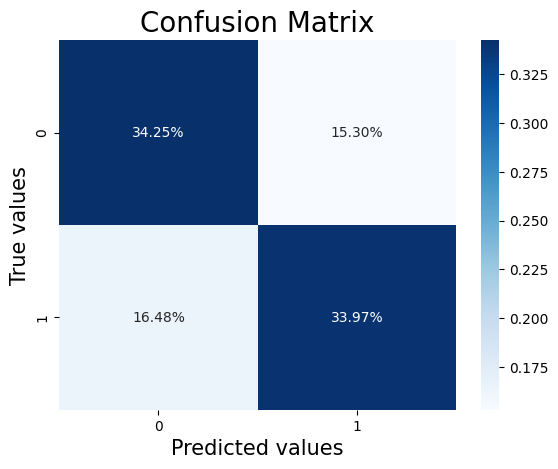

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      2445
           1       0.69      0.67      0.68      2489

    accuracy                           0.68      4934
   macro avg       0.68      0.68      0.68      4934
weighted avg       0.68      0.68      0.68      4934

ROC AUC Score: 0.68


In [ ]:
clf.predict_proba(Z_TEST)
predicted = clf.predict(Z_TEST)
# Print Confusion Matrix
confusionMatrix = metrics.confusion_matrix(Y_TEST, predicted)
print(confusionMatrix)
# The confusion matrix showing percentages of each group
ax = sns.heatmap(confusionMatrix / np.sum(confusionMatrix), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted values', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True values', fontsize = 15) # y-axis label with fontsize 15
plt.show()
# Print Classification Report
# Calculate the ROC AUC
roc_auc = roc_auc_score(Y_TEST, predicted)
print(metrics.classification_report(Y_TEST, predicted))
print(f'ROC AUC Score: {roc_auc:.2f}')
res[label] = roc_auc


In [ ]:
# Merge based on a common column ('ID' in this case)
df_train = pd.merge(X_undersampled, y_undersampled, left_index=True, right_index=True)

In [ ]:
df_train['TARGET']

81079     0
270183    0
108392    0
52475     0
71785     0
         ..
304462    1
304489    1
304495    1
304503    1
304523    1
Name: TARGET, Length: 49332, dtype: int64

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoding = 'ohe'
n_folds = 5
# Extract the labels for training
features = X_undersampled
labels = y_undersampled
# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
features = np.array(features)
labels = np.array(labels)
# Create the kfold object
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):

# Training data for the fold
  train_features, train_labels = features[train_indices], labels[train_indices]
# Validation data for the fold
  valid_features, valid_labels = features[valid_indices], labels[valid_indices]

# Create the model
  model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

# Train the model
  model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = 'auto',
                  callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(200)])

# Record the best iteration
  best_iteration = model.best_iteration_

# Record the feature importances
  feature_importance_values += model.feature_importances_ / k_fold.n_splits

# Record the out of fold predictions
  out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

  # Record the best score
  valid_score = model.best_score_['valid']['auc']
  train_score = model.best_score_['train']['auc']

  valid_scores.append(valid_score)
  train_scores.append(train_score)

  # Clean up memory
  gc.enable()
  del model, train_features, valid_features
  gc.collect()

  # Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

  # Overall validation score
valid_auc = roc_auc_score(labels, out_of_fold)

  # Add the overall scores to the metrics
valid_scores.append(valid_auc)
train_scores.append(np.mean(train_scores))

  # Needed for creating dataframe of validation scores
fold_names = list(range(n_folds))
fold_names.append('overall')

    # Dataframe of validation scores
metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

print(feature_importances)
print(metrics)

[LightGBM] [Info] Number of positive: 19662, number of negative: 19803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 39465, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.818117	train's binary_logloss: 0.530738	valid's auc: 0.756691	valid's binary_logloss: 0.58611
Early stopping, best iteration is:
[158]	train's auc: 0.807078	train's binary_logloss: 0.541618	valid's auc: 0.75687	valid's binary_logloss: 0.586074
[LightGBM] [Info] Number of positive: 19752, number of negative: 19713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024149 seconds.
You 

In [ ]:
encoding = 'ohe'
n_folds = 5
# Extract the labels for training
features = X
labels = y
# Extract feature names
feature_names = list(features.columns)

# Convert to np arrays
features = np.array(features)
labels = np.array(labels)
# Create the kfold object
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):

# Training data for the fold
  train_features, train_labels = features[train_indices], labels[train_indices]
# Validation data for the fold
  valid_features, valid_labels = features[valid_indices], labels[valid_indices]

# Create the model
  model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

# Train the model
  model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = 'auto',
                  callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(200)])

# Record the best iteration
  best_iteration = model.best_iteration_

# Record the feature importances
  feature_importance_values += model.feature_importances_ / k_fold.n_splits

# Record the out of fold predictions
  out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

  # Record the best score
  valid_score = model.best_score_['valid']['auc']
  train_score = model.best_score_['train']['auc']

  valid_scores.append(valid_score)
  train_scores.append(train_score)

  # Clean up memory
  gc.enable()
  del model, train_features, valid_features
  gc.collect()

  # Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

  # Overall validation score
valid_auc = roc_auc_score(labels, out_of_fold)

  # Add the overall scores to the metrics
valid_scores.append(valid_auc)
train_scores.append(np.mean(train_scores))

  # Needed for creating dataframe of validation scores
fold_names = list(range(n_folds))
fold_names.append('overall')

    # Dataframe of validation scores
metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

print(feature_importances)
print(metrics)

[LightGBM] [Info] Number of positive: 19768, number of negative: 223852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.448584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5129
[LightGBM] [Info] Number of data points in the train set: 243620, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.795125	train's binary_logloss: 0.550898	valid's auc: 0.75988	valid's binary_logloss: 0.566729
[400]	train's auc: 0.82536	train's binary_logloss: 0.521264	valid's auc: 0.760457	valid's binary_logloss: 0.548403
Early stopping, best iteration is:
[420]	train's auc: 0.82813	train's binary_logloss: 0.518527	valid's auc: 0.760643	valid's binary_logloss: 0.5466

In [ ]:
metrics

,fold,train,valid
0,0,0.828130,0.760643
1,1,0.803422,0.759579
2,2,0.814120,0.756741
3,3,0.813572,0.754929
4,4,0.806006,0.756535
5,overall,0.813050,0.757644
